# Context and objectives
Every week Marley Spoon customers receive a survey to measure their satisfaction with their box 3 days after they receive it. This survey measures:
- Customer satisfaction about Delivery.
- Customer satisfaction about Ingredient Quality.
- The likelihood of Repurchase. 

The objective is to analyse Customer KPI’s in order to:
- More precisely, be able to predict churn
- More generally, provide actionable insights

Here are the steps that we have followed during this case study:
- Exploration of the data
- Retro-Engineering of the aggregated scores (ie find how they have been computed)
- Build a labeled dataset with customers who churn and customers who did not churn (with the features from the CSAT dataset)
- Show the difference of characteristics between the customers who churn and the ones that did not churn
- Compute the average metrics for each couple of market and brand
- Build a model that predicts customer churn

Let us deep dive into the analysis and give some insights throughout the analysis.


# Data acquiring

## Import CSAT data
Here, we load the datasets, rename some columns for better clarity, and we show general statistics about the data.

In [1]:
PLOT_WIDTH = 12
RANDOM_STATE = 4213500

import datetime

import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_colwidth",200)

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (PLOT_WIDTH, 6) # size of the plot
import seaborn as sns
sns.set_theme(style="whitegrid")

from imblearn.over_sampling import ADASYN 

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split


from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from typing import List
from typing import Iterable
from typing import Tuple



In [2]:
# Load the CSATS Dataset
df_csat = pd.read_csv("data/CSATS_data.csv", sep=';', skiprows=1)
print(df_csat.shape)
df_csat.head()

(18437, 19)


,Start Date,"How satisfied are you with the first impression, look and feel, assembly, attention to detail and ca","In addition, for the box that you received this week, how satisfied are you with the following: - Fulfilment and Presentation","In addition, for the box that you received this week, how satisfied are you with the following: - Packaging Quality","In addition, for the box that you received this week, how satisfied are you with the following: - Ease of Recycling","How does the quality of the ingredients compare to what you would purchase for yourself? - Dry Goods (e.g. cans, bread, pasta, etc.)","How does the quality of the ingredients compare to what you would purchase for yourself? - Meat, Poultry, and Fish","How does the quality of the ingredients compare to what you would purchase for yourself? - Plant-Based Protein (e.g. tofu, tempeh, seitan, etc.)","How does the quality of the ingredients compare to what you would purchase for yourself? - Dairy (e.g. milk, yogurt, cheese, etc.)",How does the quality of the ingredients compare to what you would purchase for yourself? - Fruits and Vegetables,How likely will you purchase a next box from us?,Ingredient Quality CSAT Score,Packaging Quality CSAT Score,u,brand,country,Fulfillment Center,Ingredient Quality CSAT Score.1,Packaging Quality CSAT Score.1
0,2020-08-01 00:12:08,Very Satisfied ??,Very Satisfied ??,Very Satisfied ??,Very Satisfied ??,Same Quality,Same Quality,NaN,NaN,Same Quality,Very Likely,180.0,200.0,1733998.0,ms,nl,NWG,60.0,100.0
1,2020-08-01 00:17:12,Very Satisfied ??,Very Satisfied ??,Very Satisfied ??,Satisfied,Same Quality,Same Quality,Same Quality,NaN,Same Quality,Very Likely,240.0,180.0,1756827.0,ms,au,MEL1,60.0,90.0
2,2020-08-01 00:14:51,Very Satisfied ??,Very Satisfied ??,Satisfied,Satisfied,Same Quality,Same Quality,Same Quality,Same Quality,Same Quality,Extremely Likely,300.0,160.0,1391115.0,ms,be,NWG,60.0,80.0
3,2020-07-25 00:23:58,Very Satisfied ??,Very Satisfied ??,Very Satisfied ??,Very Satisfied ??,NaN,NaN,NaN,NaN,NaN,NaN,NaN,200.0,1766196.0,ms,au,MEL1,NaN,NaN
4,2020-08-01 00:17:42,Satisfied,Satisfied,Very Satisfied ??,Very Satisfied ??,Same Quality,Same Quality,Same Quality,NaN,Same Quality,Extremely Likely,240.0,200.0,1813814.0,ms,au,MEL1,60.0,100.0


In [3]:
# Rename the columns of the CSATS Dataset, for clarity and simplicity 
dict_col_transfo_for_df_csat = {
    "Start Date": 
    "csat_date",
    "How satisfied are you with the first impression, look and feel, assembly, attention to detail and ca": 
    "delivery_first_impression",
    "In addition, for the box that you received this week, how satisfied are you with the following: - Fulfilment and Presentation": 
    "delivery_fulfilment",
    "In addition, for the box that you received this week, how satisfied are you with the following: - Packaging Quality": 
    "delivery_packaging",
    "In addition, for the box that you received this week, how satisfied are you with the following: - Ease of Recycling": 
    "delivery_recycling",
    "How does the quality of the ingredients compare to what you would purchase for yourself? - Dry Goods (e.g. cans, bread, pasta, etc.)": 
    "ingredient_dry_good",
    "How does the quality of the ingredients compare to what you would purchase for yourself? - Meat, Poultry, and Fish": 
    "ingredient_animal_protein",
    "How does the quality of the ingredients compare to what you would purchase for yourself? - Plant-Based Protein (e.g. tofu, tempeh, seitan, etc.)": 
    "ingredient_plant_protein",
    "How does the quality of the ingredients compare to what you would purchase for yourself? - Dairy (e.g. milk, yogurt, cheese, etc.)": 
    "ingredient_dairy",
    "How does the quality of the ingredients compare to what you would purchase for yourself? - Fruits and Vegetables": 
    "ingredient_fruit_vegetable",
    "How likely will you purchase a next box from us?": 
    "repurchase",
    "Ingredient Quality CSAT Score": 
    "ingredient_score_0",
    "Packaging Quality CSAT Score": 
    "delivery_score_0",
    "u": 
    "customer_id",
    "Fulfillment Center": 
    "fulfillment_center",
    "Ingredient Quality CSAT Score.1": 
    "ingredient_score_1",
    "Packaging Quality CSAT Score.1": 
    "delivery_score_1",
}
df_csat = df_csat.rename(
    index=str, 
    columns=dict_col_transfo_for_df_csat,
)

# Re-order the columns of the CSATS Dataset
df_csat = df_csat[[
    'csat_date', 
    'customer_id', 
    'country', 
    
    'delivery_first_impression', 
    'delivery_fulfilment',
    'delivery_packaging', 
    'delivery_recycling', 
    'delivery_score_0', 
    'delivery_score_1',
    
    'ingredient_dry_good',
    'ingredient_animal_protein', 
    'ingredient_plant_protein',
    'ingredient_dairy', 
    'ingredient_fruit_vegetable', 
    'ingredient_score_0', 
    'ingredient_score_1', 
        
    'brand',
    'fulfillment_center', 
    
    'repurchase',
]]

df_csat.head()

,csat_date,customer_id,country,delivery_first_impression,delivery_fulfilment,delivery_packaging,delivery_recycling,delivery_score_0,delivery_score_1,ingredient_dry_good,ingredient_animal_protein,ingredient_plant_protein,ingredient_dairy,ingredient_fruit_vegetable,ingredient_score_0,ingredient_score_1,brand,fulfillment_center,repurchase
0,2020-08-01 00:12:08,1733998.0,nl,Very Satisfied ??,Very Satisfied ??,Very Satisfied ??,Very Satisfied ??,200.0,100.0,Same Quality,Same Quality,NaN,NaN,Same Quality,180.0,60.0,ms,NWG,Very Likely
1,2020-08-01 00:17:12,1756827.0,au,Very Satisfied ??,Very Satisfied ??,Very Satisfied ??,Satisfied,180.0,90.0,Same Quality,Same Quality,Same Quality,NaN,Same Quality,240.0,60.0,ms,MEL1,Very Likely
2,2020-08-01 00:14:51,1391115.0,be,Very Satisfied ??,Very Satisfied ??,Satisfied,Satisfied,160.0,80.0,Same Quality,Same Quality,Same Quality,Same Quality,Same Quality,300.0,60.0,ms,NWG,Extremely Likely
3,2020-07-25 00:23:58,1766196.0,au,Very Satisfied ??,Very Satisfied ??,Very Satisfied ??,Very Satisfied ??,200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ms,MEL1,NaN
4,2020-08-01 00:17:42,1813814.0,au,Satisfied,Satisfied,Very Satisfied ??,Very Satisfied ??,200.0,100.0,Same Quality,Same Quality,Same Quality,NaN,Same Quality,240.0,60.0,ms,MEL1,Extremely Likely


In [4]:
# Describe general statistics about the CSATS Dataset
print(len(df_csat))
df_csat.describe(include="all")

18437


,csat_date,customer_id,country,delivery_first_impression,delivery_fulfilment,delivery_packaging,delivery_recycling,delivery_score_0,delivery_score_1,ingredient_dry_good,ingredient_animal_protein,ingredient_plant_protein,ingredient_dairy,ingredient_fruit_vegetable,ingredient_score_0,ingredient_score_1,brand,fulfillment_center,repurchase
count,18437,1.843600e+04,18435,18434,17989,17828,17741,17930.000000,14161.000000,14665,14709,6829,13665,15200,15566.000000,13911.000000,18435,18418,14234
unique,18331,NaN,8,5,5,5,5,NaN,NaN,5,5,5,5,5,NaN,NaN,2,6,5
top,2020-09-24 09:01:34,NaN,us,Very Satisfied ??,Very Satisfied ??,Very Satisfied ??,Satisfied,NaN,NaN,Same Quality,Same Quality,Same Quality,Same Quality,Same Quality,NaN,NaN,ms,TEX1,Very Likely
freq,3,NaN,10288,7475,6228,6633,6304,NaN,NaN,10228,7573,4386,9208,7661,NaN,NaN,9879,5313,4178
mean,NaN,1.682988e+06,NaN,NaN,NaN,NaN,NaN,149.170106,76.947956,NaN,NaN,NaN,NaN,NaN,263.422845,62.798649,NaN,NaN,NaN
std,NaN,3.254410e+05,NaN,NaN,NaN,NaN,NaN,46.618400,20.726376,NaN,NaN,NaN,NaN,NaN,82.112187,15.104841,NaN,NaN,NaN
min,NaN,2.341000e+03,NaN,NaN,NaN,NaN,NaN,20.000000,20.000000,NaN,NaN,NaN,NaN,NaN,0.000000,20.000000,NaN,NaN,NaN
25%,NaN,1.637030e+06,NaN,NaN,NaN,NaN,NaN,120.000000,60.000000,NaN,NaN,NaN,NaN,NaN,220.000000,55.000000,NaN,NaN,NaN
50%,NaN,1.814056e+06,NaN,NaN,NaN,NaN,NaN,160.000000,80.000000,NaN,NaN,NaN,NaN,NaN,260.000000,60.000000,NaN,NaN,NaN
75%,NaN,1.865805e+06,NaN,NaN,NaN,NaN,NaN,200.000000,100.000000,NaN,NaN,NaN,NaN,NaN,300.000000,70.000000,NaN,NaN,NaN


## Import Churn data

In [5]:
# Load the of the Churn Dataset
df_churn = pd.read_csv("data/Churn_data.csv", sep=';')
print(df_churn.shape)
df_churn.head()

(75194, 6)


,02. Customers Customer ID,02. Customers Brand,02. Customers Country,03. User Events Created Date,03. User Events Event Reason,05. Location Production Site
0,30927,ms,de,29/09/2020,the_recipes_dont_vary_enough,NWG
1,32781,ms,de,29/09/2020,i_prefer_another_meal_kit_to_marley_spoon,NWG
2,56540,ms,de,29/09/2020,i_travel_often,NWG
3,57161,ms,nl,29/09/2020,i_prefer_another_meal_kit_to_marley_spoon,NWG
4,72287,ms,nl,29/09/2020,i_was_missing_ingredients,NWG


In [6]:
# Rename the columns of the Churn Dataset, for clarity and simplicity 
dict_col_transfo_for_df_churn = {
    "02. Customers Customer ID":"customer_id",
    "02. Customers Brand":"brand",
    "02. Customers Country":"country",
    "03. User Events Created Date":"churn_date",
    "03. User Events Event Reason":"event_reason",
    "05. Location Production Site":"production_site",
}
df_churn = df_churn.rename(
    index=str, 
    columns=dict_col_transfo_for_df_churn,
)

# Re-order the columns of the Churn Dataset
df_churn = df_churn[[
    'churn_date',
    'customer_id', 
    'country',
    'brand', 
    'event_reason',
    'production_site',
]]

df_churn.head()

,churn_date,customer_id,country,brand,event_reason,production_site
0,29/09/2020,30927,de,ms,the_recipes_dont_vary_enough,NWG
1,29/09/2020,32781,de,ms,i_prefer_another_meal_kit_to_marley_spoon,NWG
2,29/09/2020,56540,de,ms,i_travel_often,NWG
3,29/09/2020,57161,nl,ms,i_prefer_another_meal_kit_to_marley_spoon,NWG
4,29/09/2020,72287,nl,ms,i_was_missing_ingredients,NWG


In [7]:
# Describe general statistics about the Churn Dataset
print(len(df_churn))
df_churn.describe(include="all")

75194


,churn_date,customer_id,country,brand,event_reason,production_site
count,75194,7.519400e+04,75194,75194,75194,75194
unique,29,NaN,8,2,37,7
top,28/09/2020,NaN,us,ms,it_does_not_fit_my_budget,TEX1
freq,3235,NaN,33936,43030,9469,20337
mean,NaN,1.652298e+06,NaN,NaN,NaN,NaN
std,NaN,3.905199e+05,NaN,NaN,NaN,NaN
min,NaN,8.540000e+02,NaN,NaN,NaN,NaN
25%,NaN,1.554713e+06,NaN,NaN,NaN,NaN
50%,NaN,1.835236e+06,NaN,NaN,NaN,NaN
75%,NaN,1.900456e+06,NaN,NaN,NaN,NaN


# Data exploration and some Data Wrangling/Encoding
Here, we explore the datasets, and make some simple cleaning too (formatting, straitforward encoding, etc.).

## Filter rows without customer id

In [8]:
# In the general statistics, we notice there is only one missing value for customer_id
df_csat[df_csat["customer_id"].isnull()]

,csat_date,customer_id,country,delivery_first_impression,delivery_fulfilment,delivery_packaging,delivery_recycling,delivery_score_0,delivery_score_1,ingredient_dry_good,ingredient_animal_protein,ingredient_plant_protein,ingredient_dairy,ingredient_fruit_vegetable,ingredient_score_0,ingredient_score_1,brand,fulfillment_center,repurchase
9899,2020-08-31 07:47:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# We remove it (as it brings no value for our case study)
df_csat = df_csat[~df_csat["customer_id"].isnull()]


## Exploration of dates and format conversion

In [10]:
# Convert the date value for the CSAT Dataset
df_csat["fe_csat_date"] = df_csat["csat_date"].map(lambda x: x[:10])
df_csat["fe_csat_date"] = df_csat["fe_csat_date"].astype("datetime64")
df_csat.drop(columns=["csat_date"], inplace=True)

Start date min is 2020-07-24 00:00:00
Start date max is 2020-09-30 00:00:00


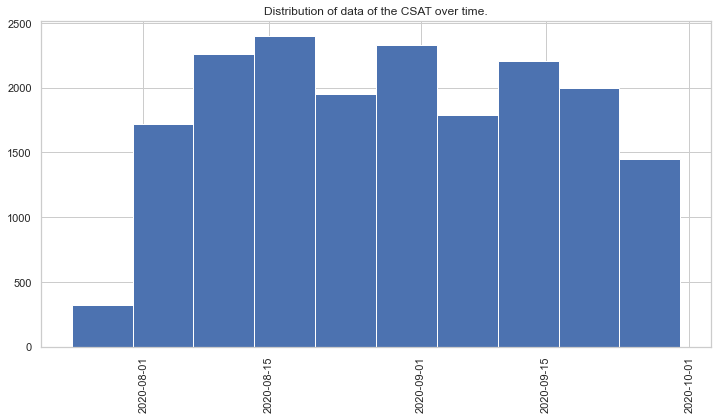

In [11]:
# We notice here, that the CSAT Dataset goes from the end of July to the end of September
print(f'Start date min is {df_csat["fe_csat_date"].min()}')
print(f'Start date max is {df_csat["fe_csat_date"].max()}')
    
# Have a look to the distribution of the data over time
plt.hist(df_csat["fe_csat_date"])
plt.xticks(rotation=90)
plt.title("Distribution of data of the CSAT over time.")
plt.show()

In [12]:
# Convert the date value for the Churn Dataset
df_churn['fe_churn_date'] = pd.to_datetime(df_churn['churn_date'], format='%d/%m/%Y')
df_churn.drop(columns=["churn_date"], inplace=True)

Start date min is 2020-09-01 00:00:00
Start date max is 2020-09-29 00:00:00


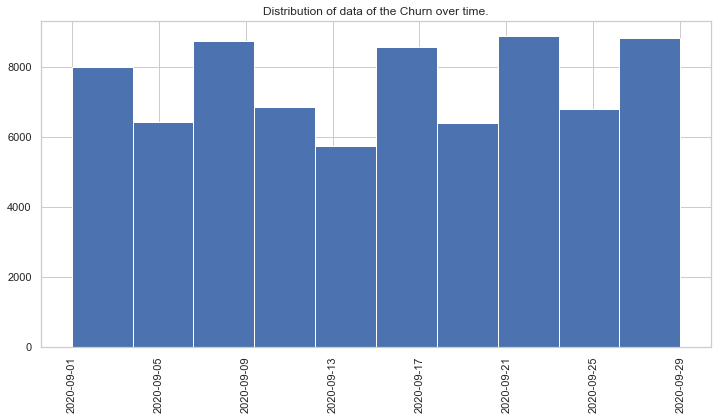

In [13]:
# We notice here, that the Churn Dataset concerns the month of September
print(f'Start date min is {df_churn["fe_churn_date"].min()}')
print(f'Start date max is {df_churn["fe_churn_date"].max()}')
    
# Have a look to the distribution of the data over time
plt.hist(df_churn["fe_churn_date"])
plt.xticks(rotation=90)
plt.title("Distribution of data of the Churn over time.")
plt.show()

## Explore the Feature "event_reason"

In [14]:
# Here, we list all churn reasons, and we notice the diversity of the reasons
# Later, we split these reasons into multiple groups
df_churn["event_reason"].value_counts()

it_does_not_fit_my_budget                                            9469
my_family_situation_is_changing                                      7094
i_dont_want_a_subscription_and_would_prefer_single_orders            6729
i_travel_often                                                       5651
i_want_to_try_a_different_meal_kit                                   5444
i_want_to_try_the_product_before_subscribing                         3778
the_ingredients_do_not_fit_my_dietary_requirements                   3521
email_no_reason                                                      3204
the_quality_of_ingredients_was_disappointing                         2790
i_need_more_meal_planning_flexibility                                2618
the_recipes_are_boring                                               2254
its_not_good_value_for_money                                         2199
the_recipes_dont_vary_enough                                         2112
payment_failure                       

In [15]:
# We split the reasons of churn into 2 groups:
# 1) the first group concerns reasons about the delivery and the ingredient (directly of indirecly)
# ... and we also added the reasons in relation with the recipe (as we feel it may be indirectly related to the ingredient)
list_unhappy_with_delivery_or_ingredient_reason = [
    'the_ingredients_do_not_fit_my_dietary_requirements', 
    'the_quality_of_ingredients_was_disappointing',
    'its_not_good_value_for_money', 
    'the_portion_sizes_are_too_small',
    'the_recipes_take_too_long_to_cook',
    'i_prefer_another_meal_kit_to_marley_spoon',
    'there_is_too_much_packaging', 
    'i_was_missing_ingredients',
    'my_delivery_was_delayed', 
    'my_delivery_was_damaged',
    'ingredients_were_damaged',
    'i_didnt_receive_my_box', 
    'the_recipes_are_too_exotic',
    'delivery_instructions_were_not_followed',
    'the_recipes_dont_vary_enough',
    'the_recipes_are_boring',
    'i_want_to_try_a_different_meal_kit',

]

# 2) other reasons, such as "I travel a lot" or "It does not fit my budget"
list_unhappy_with_other_reason = [
    'it_does_not_fit_my_budget', 
    'my_family_situation_is_changing',
    'i_dont_want_a_subscription_and_would_prefer_single_orders',
    'i_travel_often', 
    'i_want_to_try_the_product_before_subscribing',
    'email_no_reason',
    'i_need_more_meal_planning_flexibility', 
    'payment_failure', 
    'i_am_a_customer_of_multiple_meal_kit_services',
    'i_am_cooking_but_no_one_is_eating_my_kids_are_picky',
    'i_am_moving_out_of_your_delivery_area', 
    'website_app_was_hard_to_use', 
    'my_problem_was_not_resolved',
    'customer_service_did_not_reply_in_time', 
    'my_order_was_not_cancelled',
    'i_am_not_happy_with_the_attitude_of_the_customer_service_employee',
    'i_was_reactivated_without_my_consent', 
    'test_account',
    'marketing_account', 
    'i_will_not_able_to_use_the_service_anymore',
]


We will use these lists to compare the performaces of fulfillment centers for example, as we believe that the fulfillment center should not be judged on the customers who churn for unrelevant reasons.

## Explore the Feature "brand"

The categories that correspond to brands are the following:
- ms: **Marley Spoon**
- dn: **Dinnerly**

We will see that they are quite evenly distributed

In [16]:
# Compute the missing values about the brand in the Churn Dataset
print(f'The number of mission values is: {df_churn["brand"].isna().sum()}')
print(f'The proportion of mission values is: {df_churn["brand"].isna().mean()}')

The number of mission values is: 0
The proportion of mission values is: 0.0


In [17]:
# Have a look to the distribution of the brands in this dataset
df_churn["brand"].value_counts()

ms    43030
dn    32164
Name: brand, dtype: int64

In [18]:
# Compute the missing values about the brand in the CSAT Dataset
print(f'The number of mission values is: {df_csat["brand"].isna().sum()}')
print(f'The proportion of mission values is: {df_csat["brand"].isna().mean()}')

The number of mission values is: 1
The proportion of mission values is: 5.424170101974398e-05


In [19]:
# Have a look to the distribution of the brands in this dataset
df_csat["brand"].value_counts()

ms    9879
dn    8556
Name: brand, dtype: int64

## Explore the features "production_site" and "fulfillment center"

In [20]:
# Compute the missing values about the production site in the Churn Dataset
print(f'The number of mission values is: {df_churn["production_site"].isna().sum()}')
print(f'The proportion of mission values is: {df_churn["production_site"].isna().mean()}')

The number of mission values is: 0
The proportion of mission values is: 0.0


In [21]:
# Have a look to the distribution
df_churn["production_site"].value_counts()

TEX1      20337
SYD1      14466
MEL1      14216
NWG       12029
NYC1       8214
CA1        5385
EXT-NL      547
Name: production_site, dtype: int64

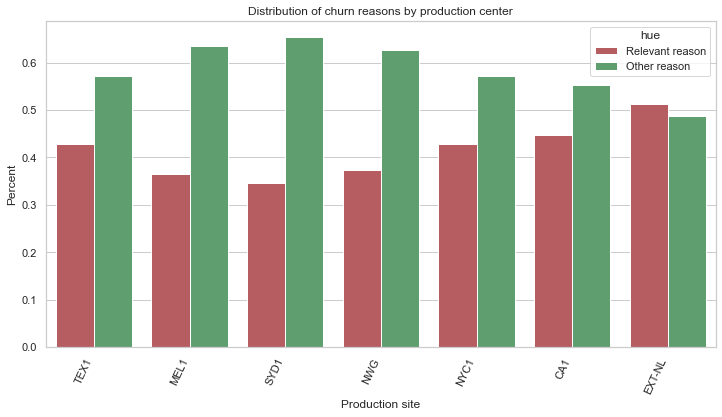

In [22]:
# Here, we will compare the production sites with regards to the reasons of churn
# ... thanks to the separation of the list of reasons into 2 groups

value_counts_global = df_churn["production_site"].value_counts()

df_churn_unhappy_with_delivery_or_ingredient_reason = df_churn[
    df_churn["event_reason"].isin(list_unhappy_with_delivery_or_ingredient_reason)
]
value_count_1 = df_churn_unhappy_with_delivery_or_ingredient_reason["production_site"].value_counts()
value_count_1 = value_count_1 / (value_counts_global[value_count_1.index].values)

df_churn_unhappy_with_other_reason = df_churn[
    df_churn["event_reason"].isin(list_unhappy_with_other_reason)
]
value_count_2 = df_churn_unhappy_with_other_reason["production_site"].value_counts()
value_count_2 = value_count_2 / (value_counts_global[value_count_2.index].values)


df_to_viz = pd.DataFrame({
    "Production site": list(value_count_1.index) + list(value_count_2.index),
    "Percent": list(value_count_1.values) + list(value_count_2.values),
    "hue": ["Relevant reason"] * len(value_count_1) + ["Other reason"] * len(value_count_2),
})

chart = sns.barplot(x="Production site", y="Percent", hue="hue", data=df_to_viz, 
                 palette={"Other reason":"g", "Relevant reason":"r"}
                   )
xtick = chart.set_xticklabels(chart.get_xticklabels(), rotation=65, horizontalalignment='right')
title = chart.set_title("Distribution of churn reasons by production center")


We notice that the distribution changes slightly when we compare the "relevant reasons" (the reasons in relation with delivery, ingredient or similar), with other reasons.
Specifically, we can say that:
- Production centers such **EXT-NL** have more customers churn in relation with delivery and ingredient reasons
- Production centers such **SYD1** & **MEL1** do a relatively better job!

In [23]:
# Compute the missing values about the fulfillment center in the CSATS Dataset
print(f'The number of mission values is: {df_csat["fulfillment_center"].isna().sum()}')
print(f'The proportion of mission values is: {df_csat["fulfillment_center"].isna().mean()}')

The number of mission values is: 18
The proportion of mission values is: 0.0009763506183553916


In [24]:
# Have a look to the distribution 
df_csat["fulfillment_center"].value_counts()

TEX1    5313
MEL1    3188
SYD1    3004
NYC1    2627
CA1     2342
NWG     1944
Name: fulfillment_center, dtype: int64

##  Explore the feature country

In [25]:
# Have a look to the distribution of the contries in the Churn Dataset
df_churn["country"].value_counts()

us    33936
au    28682
de     4929
nl     4069
be     1468
dk      932
at      765
se      413
Name: country, dtype: int64

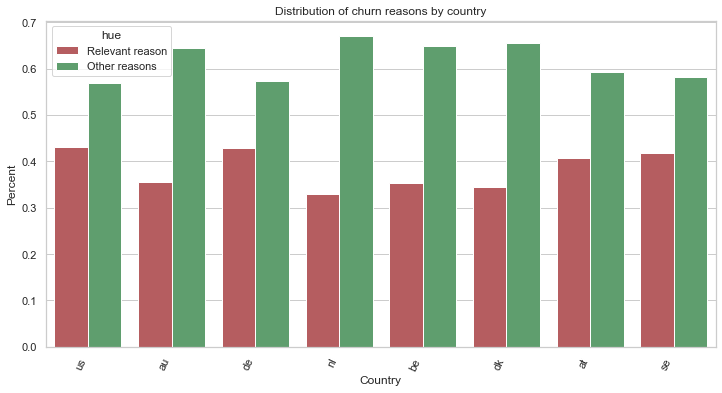

In [26]:
# Here, we will compare the coutries with regards to the reasons of churn
# ... thanks to the separation of the list of reasons into 2 groups

value_counts_global = df_churn["country"].value_counts()

df_churn_unhappy_with_delivery_or_ingredient_reason = df_churn[
    df_churn["event_reason"].isin(list_unhappy_with_delivery_or_ingredient_reason)
]
value_count_1 = df_churn_unhappy_with_delivery_or_ingredient_reason["country"].value_counts()
value_count_1 = value_count_1 /  (value_counts_global[value_count_1.index].values)

df_churn_unhappy_with_other_reason = df_churn[
    df_churn["event_reason"].isin(list_unhappy_with_other_reason)
]
value_count_2 = df_churn_unhappy_with_other_reason["country"].value_counts()
value_count_2 = value_count_2 /  (value_counts_global[value_count_2.index].values)


df_to_viz = pd.DataFrame({
    "Country": list(value_count_1.index) + list(value_count_2.index),
    "Percent": list(value_count_1.values) + list(value_count_2.values),
    "hue": ["Relevant reason"] * len(value_count_1) + ["Other reasons"] * len(value_count_2),
})

chart = sns.barplot(x="Country", y="Percent", hue="hue", data=df_to_viz, 
                 palette={"Other reasons":"g", "Relevant reason":"r"}
                   )
xtick = chart.set_xticklabels(chart.get_xticklabels(), rotation=65, horizontalalignment='right')
title = chart.set_title("Distribution of churn reasons by country")


We notice some differences in the distribution when we compare the "relevant reasons" (the reasons in relation with delivery, ingredient or similar), with other reasons.
Specifically, we can say that:
- For the **United-States** and **Germany**, customers tend, **more than other countries**, to churn for reasons in relation with Delivery and Ingredient or similar
- For **Netherlands** and **Denmark**, customers tend, **less than other countries**, to churn for reasons in relation with Delivery and Ingredient or similar

In [27]:
# Have a look to the distribution of the contries in the CSAT Dataset
df_csat["country"].value_counts()

us    10288
au     6203
de      919
nl      418
dk      208
be      195
at      125
se       79
Name: country, dtype: int64

## Explore the relation between "country" and "production site" / "fulfilment center"

In [28]:
# Explore the relation between "country" and fulfilment center"
df_csat_gp = df_csat.groupby(["country","fulfillment_center"]).count().reset_index()
df_csat_gp

,country,fulfillment_center,customer_id,delivery_first_impression,delivery_fulfilment,delivery_packaging,delivery_recycling,delivery_score_0,delivery_score_1,ingredient_dry_good,ingredient_animal_protein,ingredient_plant_protein,ingredient_dairy,ingredient_fruit_vegetable,ingredient_score_0,ingredient_score_1,brand,repurchase,fe_csat_date
0,at,NWG,125,125,120,119,120,120,106,104,104,61,104,106,110,105,125,110,125
1,au,MEL1,3188,3188,3153,3134,3127,3146,2541,2672,2662,1473,2309,2778,2837,2528,3188,2558,3188
2,au,SYD1,3004,3004,2941,2923,2915,2936,2328,2426,2429,1335,2131,2520,2597,2303,3004,2351,3004
3,be,NWG,195,195,191,190,187,191,144,154,150,147,145,153,159,140,195,144,195
4,de,NWG,919,918,899,892,889,898,769,768,718,412,755,799,810,753,919,773,919
5,dk,NWG,208,208,203,205,200,206,152,163,160,78,153,167,172,151,208,154,208
6,nl,NWG,418,417,413,407,409,412,318,341,312,308,286,326,354,313,418,320,418
7,se,NWG,79,79,74,75,75,75,59,56,58,29,53,62,62,58,79,61,79
8,us,CA1,2342,2342,2256,2220,2211,2236,1720,1764,1789,712,1737,1846,1878,1679,2342,1723,2342
9,us,NYC1,2627,2627,2532,2508,2492,2525,1925,2025,2040,754,1949,2088,2126,1875,2627,1929,2627


In [29]:
# Create a dictionary: country_to_fulfilment_center (that we will need later to fill empty values)
df_csat_gp_1 = df_csat_gp.sort_values(["country","customer_id"])
df_csat_gp_1 = df_csat_gp_1.groupby(["country"])["fulfillment_center"].last()
country_to_fulfilment_center = df_csat_gp_1.to_dict()
country_to_fulfilment_center


{'at': 'NWG',
 'au': 'MEL1',
 'be': 'NWG',
 'de': 'NWG',
 'dk': 'NWG',
 'nl': 'NWG',
 'se': 'NWG',
 'us': 'TEX1'}

In [30]:
# Create a dictionary: fulfilment_center_to_country (that we we will need later to fill empty values)
df_csat_gp_1 = df_csat_gp.sort_values(["fulfillment_center","customer_id"])
df_csat_gp_1 = df_csat_gp_1.groupby(["fulfillment_center"])["country"].last()
fulfilment_center_to_country = df_csat_gp_1.to_dict()
fulfilment_center_to_country


{'CA1': 'us',
 'MEL1': 'au',
 'NWG': 'de',
 'NYC1': 'us',
 'SYD1': 'au',
 'TEX1': 'us'}

In [31]:
# Explore the relation between "country" and "production site"
df_churn_gp = df_churn.groupby(["country","production_site"]).count().reset_index()
df_churn_gp[["country","production_site"]]

,country,production_site
0,at,NWG
1,au,MEL1
2,au,SYD1
3,be,NWG
4,de,EXT-NL
5,de,NWG
6,dk,NWG
7,nl,NWG
8,se,NWG
9,us,CA1


We notice: 
- Many countries have only one distribution site/fulfillment center
- Many distribution sites/fulfillment centers are responsible of one country each

But, we notice also:
- The **NWG** distribution site/fulfillment center is responsible for many european countries.
- The **United States** have multiple distribution sites/fulfillment centers


## Explore the relation between "brand" and "production site" / "fulfilment center"

In [32]:
# Explore the relation between "brand" and "fulfillment_center"
df_csat_gp = df_csat.groupby(["brand","fulfillment_center"]).count().reset_index()
df_csat_gp[["brand","fulfillment_center"]]

,brand,fulfillment_center
0,dn,CA1
1,dn,MEL1
2,dn,NWG
3,dn,NYC1
4,dn,SYD1
5,dn,TEX1
6,ms,CA1
7,ms,MEL1
8,ms,NWG
9,ms,NYC1


In [33]:
# Explore the relation between "brand" and "production_site"
df_churn_gp = df_churn.groupby(["brand","production_site"]).count().reset_index()
df_churn_gp[["brand","production_site"]]

,brand,production_site
0,dn,CA1
1,dn,EXT-NL
2,dn,MEL1
3,dn,NYC1
4,dn,SYD1
5,dn,TEX1
6,ms,CA1
7,ms,MEL1
8,ms,NWG
9,ms,NYC1


We observe that there is an independence between the brands and the distribution sites/fulfillment centers, which means that distribution sites/fulfillment centers are responsible for the 2 brands.

## Encode "likeliness of purchase"
Here, we base on the business inputs to encode the "likeliness of purchase" with its business value.

In [34]:
# Let us encode the value of repurchase
def repurchase_encode(x):
    if(x=="Not at all Likely"):
        return 5
    elif(x=="Not so Likely"):
        return 4
    elif(x=="Somewhat Likely"):
        return 3
    elif(x=="Very Likely"):
        return 2
    elif(x=="Extremely Likely"):
        return 1
    return x

df_csat["repurchase"] = df_csat["repurchase"].map(lambda x: repurchase_encode(x))


## Encode the "delivery" answers

In [35]:
# Let us encode the value of delivery answers
def delivery_encode(x):
    if(x=="Very Unsatisfied ??"):
        return 1
    elif(x=="Unsatisfied"):
        return 2
    elif(x=="It was OK"):
        return 3
    elif(x=="Satisfied"):
        return 4
    elif(x=="Very Satisfied ??"):
        return 5
    return x

list_col_delivery = [
    "delivery_first_impression",
    "delivery_fulfilment",
    "delivery_packaging",
    "delivery_recycling",
]

for col in list_col_delivery:
    df_csat[col] = df_csat[col].map(lambda x: delivery_encode(x))


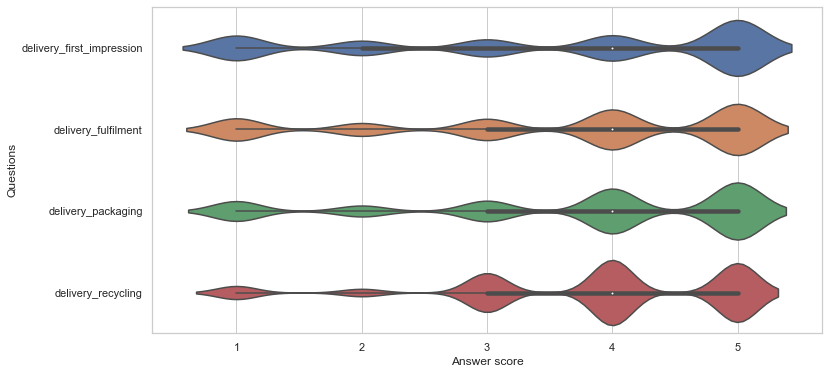

In [36]:
# Visualize the distribution of the answers for the "delivery" part
df = df_csat[list_col_delivery]
df = df.melt(var_name='Questions', value_name='Answer score')

chart = sns.violinplot(x="Answer score", y="Questions", data=df)


## Encode the "ingredient" answers

In [37]:
# Let us encode the value of ingredient answers
def ingredient_encode(x):
    if(x=="Much Worse"):
        return 1
    elif(x=="Slightly Worse"):
        return 2
    elif(x=="Same Quality"):
        return 3
    elif(x=="Slightly Better"):
        return 4
    elif(x=="Much Better"):
        return 5
    #elif(x=="Not in my Box"):
    #    return 6
    return x

list_col_ingredient = [
    "ingredient_dry_good",
    "ingredient_animal_protein",
    "ingredient_plant_protein",
    "ingredient_dairy",
    "ingredient_fruit_vegetable",
]

for col in list_col_ingredient:
    df_csat[col] = df_csat[col].map(lambda x: ingredient_encode(x))
    

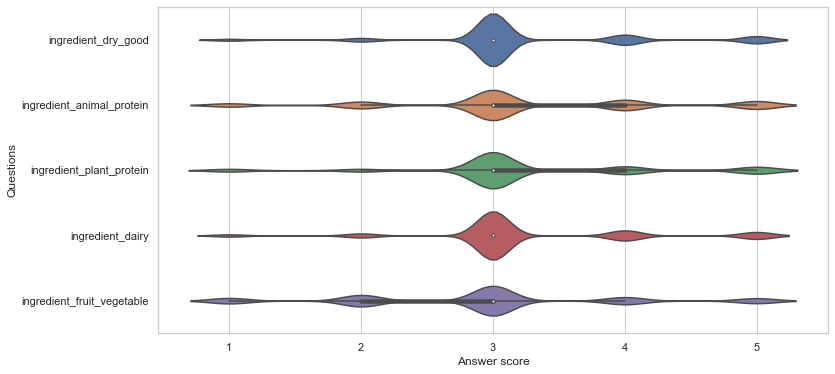

In [38]:
# Visualize the distribution of the answers for the "ingredient" part
df = df_csat[list_col_ingredient]

df = df.melt(var_name='Questions', value_name='Answer score')
ax = sns.violinplot(x="Answer score", y="Questions", data=df)

## Explore the customer id in the datasets

In [39]:
# Here, we see that there is only one churn by customer 
# ... indeed, it would be a rare event anyway, if a customer churns and then repurchases, and then churns again
list_customer_churn = list(df_churn["customer_id"])
print(len(list_customer_churn))
print(len(set(list_customer_churn)))

# Here, we see that some customers answer twice the CSAT
list_customer_csat = list(df_csat["customer_id"])
print(len(list_customer_csat))
print(len(set(list_customer_csat)))

75194
75194
18436
16419


# Retro-Engineering the scores and fill their missing values
Here, we are exploring the Scores of delivery, which seem to be aggregated scores.

In [40]:
# Let us prepare a dataset for the delivery part
df_csat_delivery = df_csat[[
    "delivery_first_impression",
    "delivery_fulfilment",
    "delivery_packaging",
    "delivery_recycling",
    "delivery_score_0",
    "delivery_score_1",
]]

In [41]:
# Let us prepare a dataset for the ingredient part
df_csat_ingredient = df_csat[[
    "ingredient_dry_good",
    "ingredient_animal_protein",
    "ingredient_plant_protein",
    "ingredient_dairy",
    "ingredient_fruit_vegetable",
    "ingredient_score_0",
    "ingredient_score_1",
]]

df_csat_ingredient.sample(5)

,ingredient_dry_good,ingredient_animal_protein,ingredient_plant_protein,ingredient_dairy,ingredient_fruit_vegetable,ingredient_score_0,ingredient_score_1
18096,5.0,5.0,NaN,5.0,5.0,400.0,100.0
13796,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15444,3.0,3.0,4.0,3.0,2.0,300.0,60.0
15875,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8147,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Understand how the score "delivery_score_0" is obtained

As it seem to be a relation between the answers to the different delivery questions and the "delivery_score_0", let us assume that it is a linear relation, and discover it.

In [42]:
# Filter empty values (for the sake of this quick analysis)
df_delivery_hyp_0 = df_csat_delivery[~df_csat_delivery[[
    "delivery_score_0",
]].isnull().any(axis=1)]

df_delivery_hyp_0 = df_delivery_hyp_0.fillna(0)

In [43]:
# Here, we use a simple Linear Regression model to find the relation
predictors = [
    "delivery_first_impression",
    "delivery_fulfilment",
    "delivery_packaging",
    "delivery_recycling",
]
X_train = df_delivery_hyp_0[predictors]
y_train = df_delivery_hyp_0["delivery_score_0"]
X_train = X_train.to_numpy()
model = LinearRegression()
model.fit(X_train, y_train)

print("Here are the coefficients:")
pd.DataFrame({
    "columns": list(predictors),
    "coef": list(abs(model.coef_)),
}).sort_values(['coef'], ascending=[0])


Here are the coefficients:


,columns,coef
2,delivery_packaging,2.000000e+01
3,delivery_recycling,2.000000e+01
1,delivery_fulfilment,2.605902e-14
0,delivery_first_impression,1.370530e-14


We discover that "delivery_score_0" is the result of aggregating the 2 last questions (**applying a sum and then multiplying by 20**).

In [44]:
# Here, we definitly prouve our assumption, 
# ...by finding no difference between our calculated column and the original one
s_diff = df_delivery_hyp_0["delivery_score_0"] - (
    df_delivery_hyp_0["delivery_packaging"] * 20 +
    df_delivery_hyp_0["delivery_recycling"] * 20
)
((s_diff).abs()).sum()

0.0

## Understand how the score "delivery_score_1" is obtained

In [45]:
# Filter empty values (for the sake of this quick analysis)
df_delivery_hyp_1 = df_csat_delivery[~df_csat_delivery[[
    "delivery_score_1",
]].isnull().any(axis=1)]

df_delivery_hyp_1.head()

,delivery_first_impression,delivery_fulfilment,delivery_packaging,delivery_recycling,delivery_score_0,delivery_score_1
0,5.0,5.0,5.0,5.0,200.0,100.0
1,5.0,5.0,5.0,4.0,180.0,90.0
2,5.0,5.0,4.0,4.0,160.0,80.0
4,4.0,4.0,5.0,5.0,200.0,100.0
6,5.0,5.0,5.0,5.0,200.0,100.0


We discover that "delivery_score_1" is the result of aggregating the 2 last questions (**applying a mean and then multiplying by 20**).
It seems to be a more realistic score, as it does not assume that the unanswered question should be rated to 0.

In [46]:
# Here, we definitly prouve our assumption 
s_diff = df_delivery_hyp_1["delivery_score_1"] - df_delivery_hyp_1[[
    "delivery_packaging",
    "delivery_recycling",   
]].apply(lambda x: x.mean()*20, axis=1)
s_diff = s_diff.abs()

# filter due to round
s_diff = s_diff.map(lambda x: 0.0 if x<0.001 else x)

# compute
s_diff.sum()

0.0

## Understand how the score "ingredient_score_0" is obtained

In [47]:
# Filter empty values (for the sake of this quick analysis)
df_ingredient_hyp_0 = df_csat_ingredient[~df_csat_ingredient[[
    "ingredient_score_0",
]].isnull().any(axis=1)]
df_ingredient_hyp_0 = df_ingredient_hyp_0.fillna(0)
df_ingredient_hyp_0.sample(5)

,ingredient_dry_good,ingredient_animal_protein,ingredient_plant_protein,ingredient_dairy,ingredient_fruit_vegetable,ingredient_score_0,ingredient_score_1
8205,3.0,3.0,3.0,3.0,3.0,300.0,60.000000
6908,3.0,4.0,0.0,3.0,2.0,240.0,60.000000
8438,3.0,3.0,0.0,3.0,3.0,240.0,0.000000
5386,4.0,0.0,4.0,0.0,3.0,220.0,73.333333
15993,5.0,5.0,5.0,5.0,5.0,500.0,0.000000


In [48]:
# Here, we use a simple Linear Regression model to find the relation
predictors = [
    "ingredient_dry_good",
    "ingredient_animal_protein",
    "ingredient_plant_protein",
    "ingredient_dairy",
    "ingredient_fruit_vegetable",
]
X_train = df_ingredient_hyp_0[predictors]
y_train = df_ingredient_hyp_0["ingredient_score_0"]
X_train = X_train.to_numpy()
model = LinearRegression()
model.fit(X_train, y_train)

print("Here are the coefficients:")
pd.DataFrame({
    "columns": list(predictors),
    "coef": list(abs(model.coef_)),
}).sort_values(['coef'], ascending=[0])


Here are the coefficients:


,columns,coef
0,ingredient_dry_good,20.0
1,ingredient_animal_protein,20.0
3,ingredient_dairy,20.0
4,ingredient_fruit_vegetable,20.0
2,ingredient_plant_protein,20.0


We discover that "ingredient_score_O" is the result of aggregating all the ingredient questions (**applying a sum and then multiplying by 20**).

In [49]:
# Here, we definitly prouve our assumption, 
# ...by finding no difference between our calculated column and the original one
s_diff = df_ingredient_hyp_0["ingredient_score_0"] - (
    df_ingredient_hyp_0["ingredient_dry_good"] * 20 +
    df_ingredient_hyp_0["ingredient_animal_protein"] * 20 +
    df_ingredient_hyp_0["ingredient_plant_protein"] * 20 +
    df_ingredient_hyp_0["ingredient_dairy"] * 20 +
    df_ingredient_hyp_0["ingredient_fruit_vegetable"] * 20
)
sum_abs_diff = ((s_diff).abs()).sum()
sum_abs_diff

0.0

## Understand how the score "ingredient_score_1" is obtained

In [50]:
# Filter empty values (for the sake of this quick analysis)
df_ingredient_hyp_1 = df_csat_ingredient[~df_csat_ingredient[[
    "ingredient_score_1",
]].isnull().any(axis=1)]

df_ingredient_hyp_1.head()

,ingredient_dry_good,ingredient_animal_protein,ingredient_plant_protein,ingredient_dairy,ingredient_fruit_vegetable,ingredient_score_0,ingredient_score_1
0,3.0,3.0,NaN,NaN,3.0,180.0,60.0
1,3.0,3.0,3.0,NaN,3.0,240.0,60.0
2,3.0,3.0,3.0,3.0,3.0,300.0,60.0
4,3.0,3.0,3.0,NaN,3.0,240.0,60.0
6,3.0,3.0,NaN,3.0,2.0,220.0,55.0


We discover that "ingredient_score_1" is the result of aggregating all the ingredient questions (**applying a mean and then multiplying by 20**).
It seems to be a more realistic score, as it does not assume that the unanswered question should be rated to 0.

In [51]:
# Here, we definitly prouve our assumption 
s_diff = df_ingredient_hyp_1["ingredient_score_1"] - (df_ingredient_hyp_1[[
    "ingredient_dry_good",
    "ingredient_animal_protein",
    "ingredient_plant_protein",
    "ingredient_dairy",
    "ingredient_fruit_vegetable",
]] * 20).apply(lambda x: x.mean(), axis=1)
s_diff = s_diff.abs()

# Additional filter due to round
s_diff = s_diff.map(lambda x: 0.0 if x<0.001 else x)
s_diff.sum()

0.0

## Fill all missing scores for delivery and ingredients

In [52]:
# Fill missing values for scores about the "delivery_score_0" (with at least on answered question)
# Apply the found formula
df_csat["fe_delivery_score_0"] = (
    df_csat["delivery_packaging"].fillna(0) * 20 + 
    df_csat["delivery_recycling"].fillna(0) * 20
)
df_csat.drop("delivery_score_0", axis=1, inplace=True)

# Fill the other missing values with 0 (as no question has been answered)
df_csat["fe_delivery_score_0"] = df_csat["fe_delivery_score_0"].fillna(0.0)



In [53]:
# Fill missing values for scores about the "delivery_score_1" (with at least on answered question)

# Check first if there are no completely empty
s_sum_null_by_row = df_csat[[
    "delivery_packaging",
    "delivery_recycling", 
]].apply(lambda x: x.isnull().sum(), axis=1)
len(s_sum_null_by_row[s_sum_null_by_row ==2])

# Apply the found formula
df_csat["fe_delivery_score_1"] = df_csat[[
    "delivery_packaging",
    "delivery_recycling",  
]].apply(lambda x: x.mean()*20, axis=1)

df_csat.drop("delivery_score_1", axis=1, inplace=True)

# Fill the other missing values with 3*20 (as no question has been answered)
# We do this because 3 is the average, and reflects truely what "ingredient_score_0" tries to capture
df_csat["fe_delivery_score_1"] = df_csat["fe_delivery_score_1"].fillna(20 * 3.0)



In [54]:
# Fill missing values for scores about the "ingredient_score_0" (with at least on answered question)
# Apply the found formula
df_csat["fe_ingredient_score_0"] = (
    df_csat["ingredient_dry_good"].fillna(0) * 20 +
    df_csat["ingredient_animal_protein"].fillna(0) * 20 +
    df_csat["ingredient_plant_protein"].fillna(0) * 20 +
    df_csat["ingredient_dairy"].fillna(0) * 20 +
    df_csat["ingredient_fruit_vegetable"].fillna(0) * 20
)
    
df_csat.drop("ingredient_score_0", axis=1, inplace=True)

# Fill the other missing values with 0 (as no question has been answered)
df_csat["fe_ingredient_score_0"] = df_csat["fe_ingredient_score_0"].fillna(3.0)


In [55]:
# Fill missing values for scores about the "ingredient_score_1" (with at least on answered question)
# Apply the found formula
df_csat["fe_ingredient_score_1"] = df_csat[[
    "ingredient_dry_good",
    "ingredient_animal_protein",
    "ingredient_plant_protein",
    "ingredient_dairy",
    "ingredient_fruit_vegetable",
]].apply(lambda x: x.mean()*20, axis=1)

df_csat.drop("ingredient_score_1", axis=1, inplace=True)

# Fill the other missing values with 3*20 (as no question has been answered)
# We do this because 3 is the average, and reflects truely what "ingredient_score_0" tries to capture
df_csat["fe_ingredient_score_1"] = df_csat["fe_ingredient_score_1"].fillna(20 * 3.0)



## Compute new aggregated scores for delivery

In [56]:
# Compute the new score "delivery_score_3" that "truely" aggregated all answers from delivery
df_csat["fe_delivery_score_3"] = (
    df_csat["delivery_first_impression"].fillna(0) * 20 + 
    df_csat["delivery_fulfilment"].fillna(0) * 20 + 
    df_csat["delivery_packaging"].fillna(0) * 20 + 
    df_csat["delivery_recycling"].fillna(0) * 20
)

# Fill the other missing values with 0 (as no question has been answered)
df_csat["fe_delivery_score_3"] = df_csat["fe_delivery_score_3"].fillna(0.0)


In [57]:
# Compute the new score "delivery_score_4" that "truely" aggregated all answers from delivery
df_csat["fe_delivery_score_4"] = df_csat[[
    "delivery_first_impression",
    "delivery_fulfilment",
    "delivery_packaging",
    "delivery_recycling",  
]].apply(lambda x: x.mean()*20, axis=1)

# Fill the other missing values with 3*20 (as no question has been answered)
# We do this because 3 is the average, and reflects truely what "ingredient_score_0" tries to capture
df_csat["fe_delivery_score_4"] = df_csat["fe_delivery_score_4"].fillna(20 * 3.0)


# Other Feature Engineering and Assumptions
We already started our Feature Engineering earlier with filling some empty values.
Here, we continue, with stronger assumptions.

## Assumption about the unanswered questions

In [58]:
# Show again the general stats
print(len(df_csat))
df_csat.describe(include="all", datetime_is_numeric=True)

18436


,customer_id,country,delivery_first_impression,delivery_fulfilment,delivery_packaging,delivery_recycling,ingredient_dry_good,ingredient_animal_protein,ingredient_plant_protein,ingredient_dairy,ingredient_fruit_vegetable,brand,fulfillment_center,repurchase,fe_csat_date,fe_delivery_score_0,fe_delivery_score_1,fe_ingredient_score_0,fe_ingredient_score_1,fe_delivery_score_3,fe_delivery_score_4
count,1.843600e+04,18435,18434.000000,17989.000000,17828.000000,17741.000000,14665.000000,14709.000000,6829.000000,13665.000000,15200.000000,18435,18418,14234.000000,18436,18436.000000,18436.000000,18436.000000,18436.000000,18436.000000,18436.000000
unique,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,us,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ms,TEX1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,10288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9879,5313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.682988e+06,NaN,3.531301,3.573517,3.706978,3.812806,3.230481,3.216194,3.239420,3.217929,2.910855,NaN,NaN,2.474357,2020-08-28 11:29:36.958125312,145.075938,74.653938,222.414841,62.454347,285.431764,72.364757
min,2.341000e+03,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,1.000000,2020-07-24 00:00:00,0.000000,20.000000,0.000000,20.000000,0.000000,20.000000
25%,1.637030e+06,NaN,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,NaN,NaN,1.000000,2020-08-14 00:00:00,120.000000,60.000000,180.000000,56.000000,220.000000,55.000000
50%,1.814056e+06,NaN,4.000000,4.000000,4.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,NaN,NaN,2.000000,2020-08-28 00:00:00,160.000000,80.000000,240.000000,60.000000,320.000000,80.000000
75%,1.865805e+06,NaN,5.000000,5.000000,5.000000,5.000000,3.000000,4.000000,4.000000,3.000000,3.000000,NaN,NaN,3.000000,2020-09-12 00:00:00,180.000000,100.000000,300.000000,66.666667,380.000000,95.000000
max,1.947497e+06,NaN,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,NaN,NaN,5.000000,2020-09-30 00:00:00,200.000000,100.000000,500.000000,100.000000,400.000000,100.000000


We make the assumption that if a customer did not answer a question, the reason can be one the following possibilies:
- Maybe he judges that the question implies an "average" response
- Maybe he did not take the time to do it
- Other reasons

Here, we suppose it is mainly the first reason.
Thus, we fill the data unanswered questions with the average which is 3.

In [59]:
# Fill the unanswered questions with the average which is 3
col_to_fill = [
    "delivery_first_impression",
    "delivery_fulfilment",
    "delivery_packaging",
    "delivery_recycling",
    
    "ingredient_dry_good",
    "ingredient_animal_protein",
    "ingredient_plant_protein",
    "ingredient_dairy",
    "ingredient_fruit_vegetable",
]

for col in col_to_fill:
    df_csat[col] = df_csat[col].fillna(3.0)


## Assumption about the unanswered repurchase question

Likewise, we fill the repurchase column with the average 3.

In [60]:
# Fill the repurchase field with the average which is 3
df_csat["repurchase"] = df_csat["repurchase"].fillna(3.0)


## Fill other missing values

In [61]:
# There seem to remain few missing values
print(len(df_csat))
print(len(df_csat[~df_csat.isnull().any(axis=1)]))

# As they are very few such values, we can drop the rows as there will be no impact on the final results
df_csat = df_csat[~df_csat.isnull().any(axis=1)]

18436
18418


## Apply some one hot encoding

In [62]:
# Apply one hot encoding for the fulfillment_center
# ... but, we will keep some of the features
df_csat["fulfillment_center"] = df_csat["fulfillment_center"].astype("category")

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(df_csat[["fulfillment_center"]])

print(f' The categories are: {enc.categories_}')
enc_df = pd.DataFrame(
    enc.transform(df_csat[["fulfillment_center"]]).toarray(),
    columns = enc.get_feature_names(['fulfillment_center'])
)
# merge with the main dataset
df_csat = df_csat.reset_index(drop=True).join(enc_df)
df_csat.head()

 The categories are: [array(['CA1', 'MEL1', 'NWG', 'NYC1', 'SYD1', 'TEX1'], dtype=object)]


,customer_id,country,delivery_first_impression,delivery_fulfilment,delivery_packaging,delivery_recycling,ingredient_dry_good,ingredient_animal_protein,ingredient_plant_protein,ingredient_dairy,ingredient_fruit_vegetable,brand,fulfillment_center,repurchase,fe_csat_date,fe_delivery_score_0,fe_delivery_score_1,fe_ingredient_score_0,fe_ingredient_score_1,fe_delivery_score_3,fe_delivery_score_4,fulfillment_center_CA1,fulfillment_center_MEL1,fulfillment_center_NWG,fulfillment_center_NYC1,fulfillment_center_SYD1,fulfillment_center_TEX1
0,1733998.0,nl,5.0,5.0,5.0,5.0,3.0,3.0,3.0,3.0,3.0,ms,NWG,2.0,2020-08-01,200.0,100.0,180.0,60.0,400.0,100.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1756827.0,au,5.0,5.0,5.0,4.0,3.0,3.0,3.0,3.0,3.0,ms,MEL1,2.0,2020-08-01,180.0,90.0,240.0,60.0,380.0,95.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1391115.0,be,5.0,5.0,4.0,4.0,3.0,3.0,3.0,3.0,3.0,ms,NWG,1.0,2020-08-01,160.0,80.0,300.0,60.0,360.0,90.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1766196.0,au,5.0,5.0,5.0,5.0,3.0,3.0,3.0,3.0,3.0,ms,MEL1,3.0,2020-07-25,200.0,100.0,0.0,60.0,400.0,100.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1813814.0,au,4.0,4.0,5.0,5.0,3.0,3.0,3.0,3.0,3.0,ms,MEL1,1.0,2020-08-01,200.0,100.0,240.0,60.0,360.0,90.0,0.0,1.0,0.0,0.0,0.0,0.0


In [63]:
# Apply one hot encoding for the country
df_csat["country"] = df_csat["country"].astype("category")

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(df_csat[["country"]])

print(f' The categories are: {enc.categories_}')
enc_df = pd.DataFrame(
    enc.transform(df_csat[["country"]]).toarray(),
    columns = enc.get_feature_names(['country'])
)
# merge with the main dataset
df_csat = df_csat.reset_index(drop=True).join(enc_df)
df_csat.head()

 The categories are: [array(['at', 'au', 'be', 'de', 'dk', 'nl', 'se', 'us'], dtype=object)]


,customer_id,country,delivery_first_impression,delivery_fulfilment,delivery_packaging,delivery_recycling,ingredient_dry_good,ingredient_animal_protein,ingredient_plant_protein,ingredient_dairy,ingredient_fruit_vegetable,brand,fulfillment_center,repurchase,fe_csat_date,fe_delivery_score_0,fe_delivery_score_1,fe_ingredient_score_0,fe_ingredient_score_1,fe_delivery_score_3,fe_delivery_score_4,fulfillment_center_CA1,fulfillment_center_MEL1,fulfillment_center_NWG,fulfillment_center_NYC1,fulfillment_center_SYD1,fulfillment_center_TEX1,country_at,country_au,country_be,country_de,country_dk,country_nl,country_se,country_us
0,1733998.0,nl,5.0,5.0,5.0,5.0,3.0,3.0,3.0,3.0,3.0,ms,NWG,2.0,2020-08-01,200.0,100.0,180.0,60.0,400.0,100.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1756827.0,au,5.0,5.0,5.0,4.0,3.0,3.0,3.0,3.0,3.0,ms,MEL1,2.0,2020-08-01,180.0,90.0,240.0,60.0,380.0,95.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1391115.0,be,5.0,5.0,4.0,4.0,3.0,3.0,3.0,3.0,3.0,ms,NWG,1.0,2020-08-01,160.0,80.0,300.0,60.0,360.0,90.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1766196.0,au,5.0,5.0,5.0,5.0,3.0,3.0,3.0,3.0,3.0,ms,MEL1,3.0,2020-07-25,200.0,100.0,0.0,60.0,400.0,100.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1813814.0,au,4.0,4.0,5.0,5.0,3.0,3.0,3.0,3.0,3.0,ms,MEL1,1.0,2020-08-01,200.0,100.0,240.0,60.0,360.0,90.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
# Apply one hot encoding for the brand
df_csat["brand"] = df_csat["brand"].astype("category")

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(df_csat[["brand"]])

print(f' The categories are: {enc.categories_}')
enc_df = pd.DataFrame(
    enc.transform(df_csat[["brand"]]).toarray(),
    columns = enc.get_feature_names(['brand'])
)
# merge with the main dataset
df_csat = df_csat.reset_index(drop=True).join(enc_df)
df_csat.head()

 The categories are: [array(['dn', 'ms'], dtype=object)]


,customer_id,country,delivery_first_impression,delivery_fulfilment,delivery_packaging,delivery_recycling,ingredient_dry_good,ingredient_animal_protein,ingredient_plant_protein,ingredient_dairy,ingredient_fruit_vegetable,brand,fulfillment_center,repurchase,fe_csat_date,fe_delivery_score_0,fe_delivery_score_1,fe_ingredient_score_0,fe_ingredient_score_1,fe_delivery_score_3,fe_delivery_score_4,fulfillment_center_CA1,fulfillment_center_MEL1,fulfillment_center_NWG,fulfillment_center_NYC1,fulfillment_center_SYD1,fulfillment_center_TEX1,country_at,country_au,country_be,country_de,country_dk,country_nl,country_se,country_us,brand_dn,brand_ms
0,1733998.0,nl,5.0,5.0,5.0,5.0,3.0,3.0,3.0,3.0,3.0,ms,NWG,2.0,2020-08-01,200.0,100.0,180.0,60.0,400.0,100.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1756827.0,au,5.0,5.0,5.0,4.0,3.0,3.0,3.0,3.0,3.0,ms,MEL1,2.0,2020-08-01,180.0,90.0,240.0,60.0,380.0,95.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1391115.0,be,5.0,5.0,4.0,4.0,3.0,3.0,3.0,3.0,3.0,ms,NWG,1.0,2020-08-01,160.0,80.0,300.0,60.0,360.0,90.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1766196.0,au,5.0,5.0,5.0,5.0,3.0,3.0,3.0,3.0,3.0,ms,MEL1,3.0,2020-07-25,200.0,100.0,0.0,60.0,400.0,100.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1813814.0,au,4.0,4.0,5.0,5.0,3.0,3.0,3.0,3.0,3.0,ms,MEL1,1.0,2020-08-01,200.0,100.0,240.0,60.0,360.0,90.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Build a labeled dataset

## Explore the customers who have answered the CSAT and have churned

In [65]:
# Find the customers who have answered the CSAT and Churned
df_intersect = pd.merge(df_csat, df_churn[[
    "customer_id",
    "fe_churn_date",
    "event_reason",
]], how='inner', left_on="customer_id", right_on="customer_id")
print(len(df_intersect))

# Compute the difference between the churn date and the CSAT date
df_intersect["date_diff"] = (df_intersect["fe_churn_date"] - df_intersect["fe_csat_date"]) / np.timedelta64(1, 'D')
df_intersect.head()

3726


,customer_id,country,delivery_first_impression,delivery_fulfilment,delivery_packaging,delivery_recycling,ingredient_dry_good,ingredient_animal_protein,ingredient_plant_protein,ingredient_dairy,ingredient_fruit_vegetable,brand,fulfillment_center,repurchase,fe_csat_date,fe_delivery_score_0,fe_delivery_score_1,fe_ingredient_score_0,fe_ingredient_score_1,fe_delivery_score_3,fe_delivery_score_4,fulfillment_center_CA1,fulfillment_center_MEL1,fulfillment_center_NWG,fulfillment_center_NYC1,fulfillment_center_SYD1,fulfillment_center_TEX1,country_at,country_au,country_be,country_de,country_dk,country_nl,country_se,country_us,brand_dn,brand_ms,fe_churn_date,event_reason,date_diff
0,1766196.0,au,5.0,5.0,5.0,5.0,3.0,3.0,3.0,3.0,3.0,ms,MEL1,3.0,2020-07-25,200.0,100.0,0.0,60.000000,400.0,100.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2020-09-24,the_ingredients_do_not_fit_my_dietary_requirements,61.0
1,1812104.0,au,5.0,5.0,4.0,4.0,3.0,3.0,3.0,3.0,4.0,ms,MEL1,3.0,2020-08-01,160.0,80.0,200.0,66.666667,360.0,90.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2020-09-27,i_want_to_try_a_different_meal_kit,57.0
2,101654.0,nl,4.0,4.0,3.0,4.0,3.0,3.0,2.0,3.0,2.0,ms,NWG,2.0,2020-08-01,140.0,70.0,260.0,52.000000,300.0,75.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2020-09-22,delivery_instructions_were_not_followed,52.0
3,1762078.0,au,5.0,1.0,1.0,5.0,3.0,3.0,3.0,3.0,3.0,ms,SYD1,2.0,2020-08-01,120.0,60.0,300.0,60.000000,240.0,60.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2020-09-27,my_family_situation_is_changing,57.0
4,1762078.0,au,3.0,3.0,2.0,3.0,3.0,3.0,3.0,3.0,2.0,ms,SYD1,3.0,2020-08-28,100.0,50.0,280.0,56.000000,220.0,55.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2020-09-27,my_family_situation_is_changing,30.0


-26.0
66.0


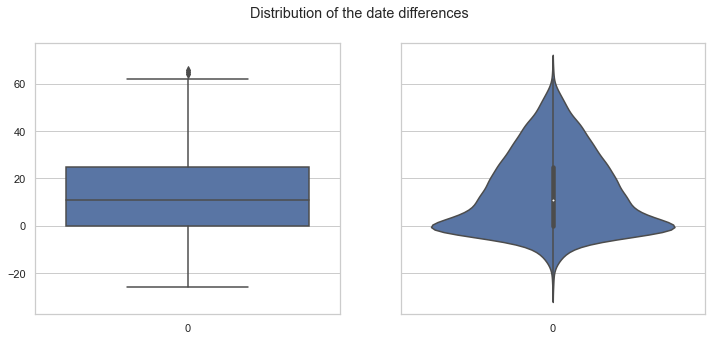

In [66]:
# Show the differences in the dates
print(df_intersect["date_diff"].min())
print(df_intersect["date_diff"].max())

# Visualize the date distribution
fig, axes = plt.subplots(1, 2, figsize=(PLOT_WIDTH, 5), sharey=True)
fig.suptitle('Distribution of the date differences')

sns.boxplot(ax=axes[0], data=df_intersect["date_diff"])
sub_title = axes[0].set_title("")

sns.violinplot(ax=axes[1], data=df_intersect["date_diff"])
sub_title = axes[1].set_title("")


## Build the dataset of customers who churn

In [67]:
# Here, we prepare the dataset for customers who churn (with their CSAT informations)
# ... we filter on the events that happened between 0 and 6 days
df_churn_yes = df_intersect[((df_intersect["date_diff"] >=0) &
                        (df_intersect["date_diff"] <=6))]


df_churn_yes.drop(columns=[
    "fe_churn_date",
    "date_diff",
], axis=1, inplace=True)

# Add a column about the status
df_churn_yes["will_churn"] = 1
print(len(df_churn_yes))

# We filter on the relevant reasons!
df_churn_yes = df_churn_yes[df_churn_yes["event_reason"].isin(list_unhappy_with_delivery_or_ingredient_reason)]
print(len(df_churn_yes))

df_churn_yes.sample(5)

734
427


/Users/nabil.belaid/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/nabil.belaid/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,customer_id,country,delivery_first_impression,delivery_fulfilment,delivery_packaging,delivery_recycling,ingredient_dry_good,ingredient_animal_protein,ingredient_plant_protein,ingredient_dairy,ingredient_fruit_vegetable,brand,fulfillment_center,repurchase,fe_csat_date,fe_delivery_score_0,fe_delivery_score_1,fe_ingredient_score_0,fe_ingredient_score_1,fe_delivery_score_3,fe_delivery_score_4,fulfillment_center_CA1,fulfillment_center_MEL1,fulfillment_center_NWG,fulfillment_center_NYC1,fulfillment_center_SYD1,fulfillment_center_TEX1,country_at,country_au,country_be,country_de,country_dk,country_nl,country_se,country_us,brand_dn,brand_ms,event_reason,will_churn
1767,1853127.0,de,5.0,5.0,5.0,5.0,4.0,4.0,4.0,4.0,4.0,ms,NWG,1.0,2020-08-31,200.0,100.0,400.0,80.0,400.0,100.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,its_not_good_value_for_money,1
1261,1856027.0,us,1.0,2.0,4.0,4.0,3.0,3.0,3.0,3.0,3.0,ms,TEX1,3.0,2020-09-12,160.0,80.0,120.0,60.0,220.0,55.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,the_quality_of_ingredients_was_disappointing,1
2626,1314733.0,us,1.0,1.0,1.0,3.0,3.0,3.0,3.0,3.0,3.0,ms,TEX1,3.0,2020-09-05,20.0,20.0,0.0,60.0,60.0,20.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,ingredients_were_damaged,1
2977,1668668.0,us,3.0,3.0,3.0,3.0,3.0,3.0,2.0,3.0,1.0,dn,TEX1,5.0,2020-09-17,120.0,60.0,180.0,45.0,240.0,60.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,ingredients_were_damaged,1
2310,1860448.0,us,4.0,4.0,5.0,5.0,3.0,5.0,3.0,3.0,5.0,ms,CA1,3.0,2020-09-01,200.0,100.0,320.0,80.0,360.0,90.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,i_want_to_try_a_different_meal_kit,1


## Build the dataset of customers who did not churn

In [68]:
# Here, we prepare the dataset for customers who did not churn (with their CSAT informations)
# ... we filter on the CSAT that will enable us to validate that the customer did not churn indeed
df_churn_no = df_csat
df_churn_no = df_churn_no[df_churn_no["fe_csat_date"] >= datetime.datetime(2020, 9, 1)]
df_churn_no = df_churn_no[df_churn_no["fe_csat_date"] < datetime.datetime(2020, 9, 23)]
print(len(df_churn_no))

l_customer_to_put_out = list(df_intersect["customer_id"])
df_churn_no = df_churn_no[~df_churn_no["customer_id"].isin(l_customer_to_put_out)]

# Add a column about the status
df_churn_no["will_churn"] = 0
print(len(df_churn_no))

df_churn_no.sample(5)

6254
4555


,customer_id,country,delivery_first_impression,delivery_fulfilment,delivery_packaging,delivery_recycling,ingredient_dry_good,ingredient_animal_protein,ingredient_plant_protein,ingredient_dairy,ingredient_fruit_vegetable,brand,fulfillment_center,repurchase,fe_csat_date,fe_delivery_score_0,fe_delivery_score_1,fe_ingredient_score_0,fe_ingredient_score_1,fe_delivery_score_3,fe_delivery_score_4,fulfillment_center_CA1,fulfillment_center_MEL1,fulfillment_center_NWG,fulfillment_center_NYC1,fulfillment_center_SYD1,fulfillment_center_TEX1,country_at,country_au,country_be,country_de,country_dk,country_nl,country_se,country_us,brand_dn,brand_ms,will_churn
14006,1733766.0,us,5.0,5.0,5.0,5.0,3.0,3.0,3.0,3.0,3.0,dn,TEX1,1.0,2020-09-14,200.0,100.0,240.0,60.0,400.0,100.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0
13219,1010457.0,de,3.0,4.0,4.0,3.0,3.0,1.0,3.0,2.0,2.0,ms,NWG,3.0,2020-09-12,140.0,70.0,220.0,44.0,280.0,70.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0
10849,1323615.0,au,5.0,5.0,5.0,4.0,3.0,2.0,3.0,3.0,2.0,ms,MEL1,3.0,2020-09-03,180.0,90.0,200.0,50.0,380.0,95.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
10401,1856787.0,au,5.0,5.0,1.0,1.0,3.0,2.0,3.0,3.0,3.0,dn,MEL1,4.0,2020-09-02,40.0,20.0,220.0,55.0,240.0,60.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
14516,1361546.0,au,1.0,1.0,1.0,3.0,3.0,3.0,3.0,3.0,3.0,dn,SYD1,4.0,2020-09-16,80.0,40.0,0.0,60.0,120.0,30.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


## Compare the 2 dataset with regards to their caracteristiques

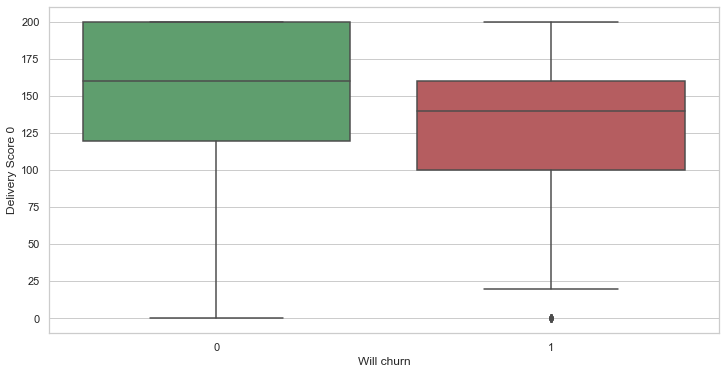

In [69]:
# Compare the 2 dataset with regards to their aggregated scores "fe_delivery_score_0"
# We see that there is indeed a tendency of worse scores for customers who churn
df_to_viz = pd.DataFrame({
    "Delivery Score 0": list(df_churn_yes["fe_delivery_score_0"]) + list(df_churn_no["fe_delivery_score_0"]),
    "Will churn": list(df_churn_yes["will_churn"]) + list(df_churn_no["will_churn"]),
})
graph = sns.boxplot(x='Will churn', y='Delivery Score 0', data=df_to_viz, 
                    palette={0:"g", 1:"r"})
#title = graph.set_title("...fe_delivery_score_0")



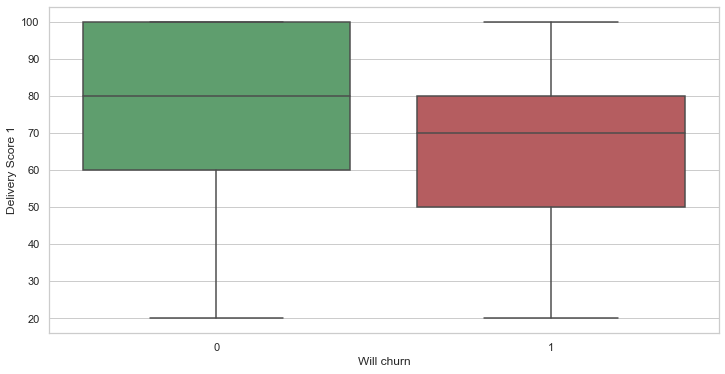

In [70]:
# Compare the 2 dataset with regards to their aggregated scores "fe_delivery_score_1"
# We see that there is indeed a tendency of worse scores for customers who churn
df_to_viz = pd.DataFrame({
    "Delivery Score 1": list(df_churn_yes["fe_delivery_score_1"]) + list(df_churn_no["fe_delivery_score_1"]),
    "Will churn": list(df_churn_yes["will_churn"]) + list(df_churn_no["will_churn"]),
})
graph = sns.boxplot(x='Will churn', y='Delivery Score 1', data=df_to_viz, 
                    palette={0:"g", 1:"r"})
#title = graph.set_title("...fe_delivery_score_1")



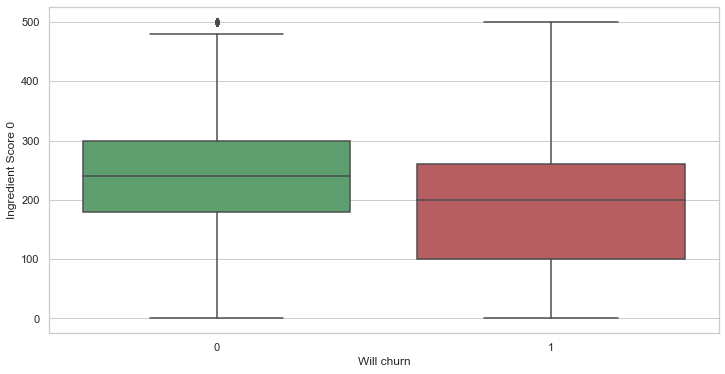

In [71]:
# Compare the 2 dataset with regards to their aggregated scores "fe_ingredient_score_0"
# We see that there is indeed a tendency of worse scores for customers who churn
df_to_viz = pd.DataFrame({
    "Ingredient Score 0": list(df_churn_yes["fe_ingredient_score_0"]) + list(df_churn_no["fe_ingredient_score_0"]),
    "Will churn": list(df_churn_yes["will_churn"]) + list(df_churn_no["will_churn"]),
})
graph = sns.boxplot(x='Will churn', y='Ingredient Score 0', data=df_to_viz, 
                    palette={0:"g", 1:"r"})
#title = graph.set_title("...fe_ingredient_score_0")



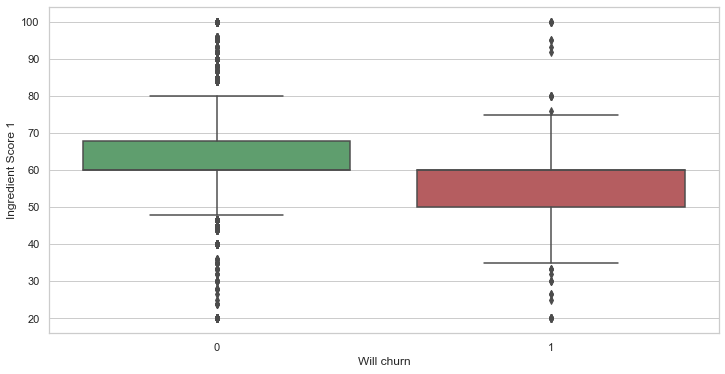

In [72]:
# Compare the 2 dataset with regards to their aggregated scores "fe_ingredient_score_1"
# We see that there is indeed a tendency of worse scores for customers who churn
df_to_viz = pd.DataFrame({
    "Ingredient Score 1": list(df_churn_yes["fe_ingredient_score_1"]) + list(df_churn_no["fe_ingredient_score_1"]),
    "Will churn": list(df_churn_yes["will_churn"]) + list(df_churn_no["will_churn"]),
})
graph = sns.boxplot(x='Will churn', y='Ingredient Score 1', data=df_to_viz, 
                    palette={0:"g", 1:"r"})
#title = graph.set_title("...fe_ingredient_score_1")



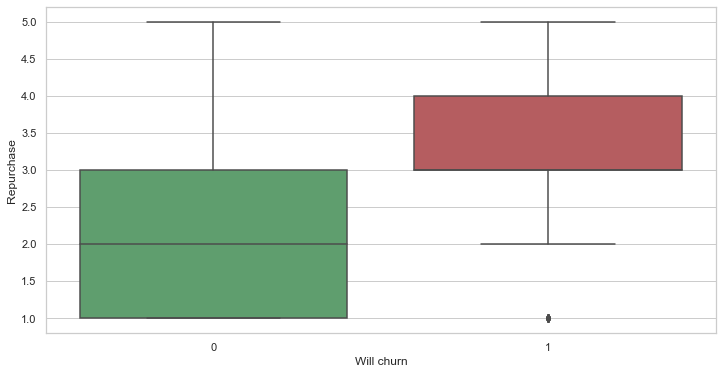

In [73]:
# Compare the 2 dataset with regards to their answer about repurchase
# There is indeed a tendency of not repurchasing when they churn (high score is worse here)
df_to_viz = pd.DataFrame({
    "Repurchase": list(df_churn_yes["repurchase"]) + list(df_churn_no["repurchase"]),
    "Will churn": list(df_churn_yes["will_churn"]) + list(df_churn_no["will_churn"]),
})
graph = sns.boxplot(x='Will churn', y='Repurchase', data=df_to_viz, 
                    palette={0:"g", 1:"r"})
#title = graph.set_title("...repurchase")



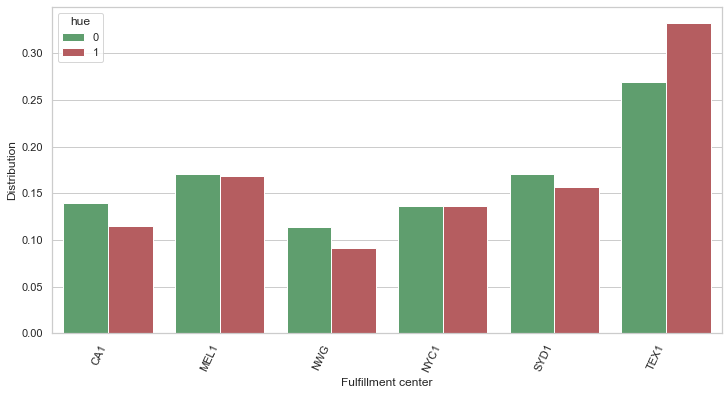

In [74]:
# Here, we compare the districution of the churn and not churn with regards to the fulfillment center
# We see that "TEX1" does worse than the others
df_churn_yes_fc = df_churn_yes[["fulfillment_center","will_churn",]]
df_churn_yes_fc_gp = df_churn_yes_fc.groupby(["fulfillment_center"]).count()
df_churn_yes_fc_gp = df_churn_yes_fc_gp.rename(columns={"will_churn":"count"}).reset_index()
df_churn_yes_fc_gp["mean_occ"] = df_churn_yes_fc_gp["count"] / len(df_churn_yes)
df_churn_yes_fc_gp["will_churn"] = 1

df_churn_no_fc = df_churn_no[["fulfillment_center","will_churn",]]
df_churn_no_fc_gp = df_churn_no_fc.groupby(["fulfillment_center"]).count()
df_churn_no_fc_gp = df_churn_no_fc_gp.rename(columns={"will_churn":"count"}).reset_index()
df_churn_no_fc_gp["mean_occ"] = df_churn_no_fc_gp["count"] / len(df_churn_no)
df_churn_no_fc_gp["will_churn"] = 0


df_to_viz = pd.DataFrame({
    "Fulfillment center": list(df_churn_yes_fc_gp["fulfillment_center"]) + list(df_churn_no_fc_gp["fulfillment_center"]),
    "Distribution": list(df_churn_yes_fc_gp["mean_occ"]) + list(df_churn_no_fc_gp["mean_occ"]),
    "hue": list(df_churn_yes_fc_gp["will_churn"]) + list(df_churn_no_fc_gp["will_churn"]),
})

chart = sns.barplot(x="Fulfillment center", y="Distribution", hue="hue", data=df_to_viz, 
                 palette={0:"g", 1:"r"})
xtick = chart.set_xticklabels(chart.get_xticklabels(), rotation=65, horizontalalignment='right')


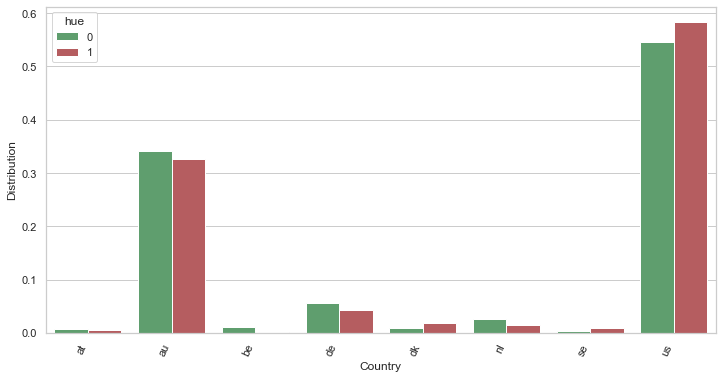

In [75]:
# Here, we compare the districution of the churn and not churn with regards to the country
df_churn_yes_fc = df_churn_yes[["country","will_churn",]]
df_churn_yes_fc_gp = df_churn_yes_fc.groupby(["country"]).count()
df_churn_yes_fc_gp = df_churn_yes_fc_gp.rename(columns={"will_churn":"count"}).reset_index()
df_churn_yes_fc_gp["mean_occ"] = df_churn_yes_fc_gp["count"] / len(df_churn_yes)
df_churn_yes_fc_gp["will_churn"] = 1

df_churn_no_fc = df_churn_no[["country","will_churn",]]
df_churn_no_fc_gp = df_churn_no_fc.groupby(["country"]).count()
df_churn_no_fc_gp = df_churn_no_fc_gp.rename(columns={"will_churn":"count"}).reset_index()
df_churn_no_fc_gp["mean_occ"] = df_churn_no_fc_gp["count"] / len(df_churn_no)
df_churn_no_fc_gp["will_churn"] = 0


df_to_viz = pd.DataFrame({
    "Country": list(df_churn_yes_fc_gp["country"]) + list(df_churn_no_fc_gp["country"]),
    "Distribution": list(df_churn_yes_fc_gp["mean_occ"]) + list(df_churn_no_fc_gp["mean_occ"]),
    "hue": list(df_churn_yes_fc_gp["will_churn"]) + list(df_churn_no_fc_gp["will_churn"]),
})

chart = sns.barplot(x="Country", y="Distribution", hue="hue", data=df_to_viz, 
                 palette={0:"g", 1:"r"})
xtick = chart.set_xticklabels(chart.get_xticklabels(), rotation=65, horizontalalignment='right')


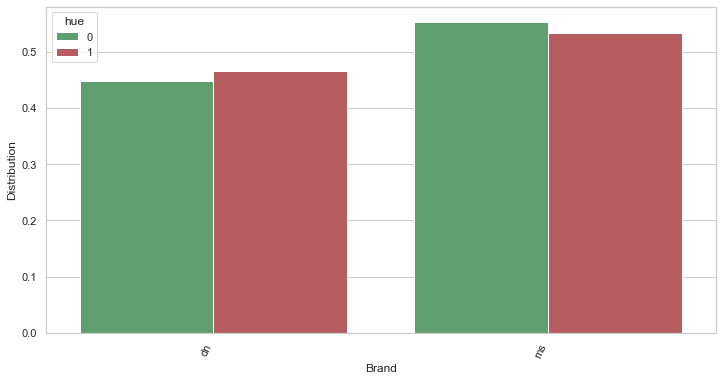

In [76]:
# Here, we compare the districution of the churn and not churn with regards to the brand
df_churn_yes_fc = df_churn_yes[["brand","will_churn",]]
df_churn_yes_fc_gp = df_churn_yes_fc.groupby(["brand"]).count()
df_churn_yes_fc_gp = df_churn_yes_fc_gp.rename(columns={"will_churn":"count"}).reset_index()
df_churn_yes_fc_gp["mean_occ"] = df_churn_yes_fc_gp["count"] / len(df_churn_yes)
df_churn_yes_fc_gp["will_churn"] = 1

df_churn_no_fc = df_churn_no[["brand","will_churn",]]
df_churn_no_fc_gp = df_churn_no_fc.groupby(["brand"]).count()
df_churn_no_fc_gp = df_churn_no_fc_gp.rename(columns={"will_churn":"count"}).reset_index()
df_churn_no_fc_gp["mean_occ"] = df_churn_no_fc_gp["count"] / len(df_churn_no)
df_churn_no_fc_gp["will_churn"] = 0


df_to_viz = pd.DataFrame({
    "Brand": list(df_churn_yes_fc_gp["brand"]) + list(df_churn_no_fc_gp["brand"]),
    "Distribution": list(df_churn_yes_fc_gp["mean_occ"]) + list(df_churn_no_fc_gp["mean_occ"]),
    "hue": list(df_churn_yes_fc_gp["will_churn"]) + list(df_churn_no_fc_gp["will_churn"]),
})

chart = sns.barplot(x="Brand", y="Distribution", hue="hue", data=df_to_viz, 
                 palette={0:"g", 1:"r"})
xtick = chart.set_xticklabels(chart.get_xticklabels(), rotation=65, horizontalalignment='right')


## Build finally the labelled dataset

In [77]:
# Merge the 2 datasets
df_churn_yes = df_churn_yes[df_churn_no.columns]
frames = [df_churn_yes, df_churn_no]
df_model = pd.concat(frames)
df_model = df_model.iloc[np.random.permutation(len(df_model))]
df_model.sample(5)

,customer_id,country,delivery_first_impression,delivery_fulfilment,delivery_packaging,delivery_recycling,ingredient_dry_good,ingredient_animal_protein,ingredient_plant_protein,ingredient_dairy,ingredient_fruit_vegetable,brand,fulfillment_center,repurchase,fe_csat_date,fe_delivery_score_0,fe_delivery_score_1,fe_ingredient_score_0,fe_ingredient_score_1,fe_delivery_score_3,fe_delivery_score_4,fulfillment_center_CA1,fulfillment_center_MEL1,fulfillment_center_NWG,fulfillment_center_NYC1,fulfillment_center_SYD1,fulfillment_center_TEX1,country_at,country_au,country_be,country_de,country_dk,country_nl,country_se,country_us,brand_dn,brand_ms,will_churn
15194,1886758.0,us,3.0,2.0,1.0,3.0,3.0,1.0,3.0,2.0,3.0,dn,TEX1,3.0,2020-09-18,80.0,40.0,180.0,45.000000,180.0,45.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0
13286,1864469.0,us,2.0,2.0,5.0,5.0,3.0,3.0,3.0,3.0,3.0,ms,NYC1,3.0,2020-09-12,200.0,100.0,0.0,60.000000,280.0,70.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0
11711,521395.0,us,5.0,5.0,5.0,5.0,3.0,4.0,3.0,4.0,3.0,ms,NYC1,4.0,2020-09-06,200.0,100.0,280.0,70.000000,400.0,100.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0
2539,1902028.0,us,3.0,2.0,4.0,4.0,3.0,3.0,3.0,3.0,2.0,ms,TEX1,3.0,2020-09-11,160.0,80.0,160.0,53.333333,260.0,65.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1
12935,1874777.0,us,1.0,2.0,2.0,5.0,3.0,3.0,3.0,3.0,2.0,dn,CA1,3.0,2020-09-11,140.0,70.0,280.0,56.000000,200.0,50.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0


In [78]:
# Let us get the distribution cases
print(f'Total number of rows: {len(df_model)}')
print(f'The distribution of cases is:')
value_counts = df_model["will_churn"].value_counts()
print(value_counts)
print(f'The proportion of churn cases is {value_counts[1] / value_counts.values.sum()}')


Total number of rows: 4982
The distribution of cases is:
0    4555
1     427
Name: will_churn, dtype: int64
The proportion of churn cases is 0.08570855078281815


# Average metrics by market and brand
Here we compute the following average performances for each brand and each country:
- Average Packaging Quality CSAT Score
- Average Packaging Quality CSAT Score.1
- Average Ingredient Quality CSAT Score
- Average Ingredient Quality CSAT Score.1
- Average declared likelihood of repurchase
- Average probability of churn
- Average true probability of repurchase

In [90]:
# Let compute the aggregations by brand and country
df_aggregation = df_model[[
    "brand",
    "country",
    "fe_delivery_score_0",
    "fe_delivery_score_1",
    "fe_ingredient_score_0",
    "fe_ingredient_score_1",
    "repurchase",
    "will_churn",
]].groupby(["brand","country"]).mean().reset_index()

# Compute the true probability of repurchase (according to the assumptions, it is the inverse of churn)
df_aggregation["will_not_churn"] = 1 - df_aggregation["will_churn"]

dict_col_to_rename_back = {
    "brand": "Brand",
    "country": "Country",
    "fe_delivery_score_0": "Average Packaging Quality CSAT Score",
    "fe_delivery_score_1": "Average Packaging Quality CSAT Score.1", 
    "fe_ingredient_score_0": "Average Ingredient Quality CSAT Score", 
    "fe_ingredient_score_1": "Average Ingredient Quality CSAT Score.1",
    "repurchase": "Average declared likelihood of repurchase",
    "will_churn": "Average probability of churn",
    "will_not_churn": "Average true probability of repurchase",
}
df_aggregation = df_aggregation.rename(
    index=str, 
    columns=dict_col_to_rename_back,
)

df_aggregation = df_aggregation[~df_aggregation.isnull().any(axis=1)]

df_aggregation = df_aggregation.sort_values(["Average probability of churn"], ascending=False)
df_aggregation.to_csv("data/Performance_by_brand_and_country_data.csv", index=False)

df_aggregation

,Brand,Country,Average Packaging Quality CSAT Score,Average Packaging Quality CSAT Score.1,Average Ingredient Quality CSAT Score,Average Ingredient Quality CSAT Score.1,Average declared likelihood of repurchase,Average probability of churn,Average true probability of repurchase
14,ms,se,138.888889,69.444444,187.777778,55.222222,3.500000,0.222222,0.777778
12,ms,dk,150.196078,75.098039,223.921569,63.183007,2.333333,0.156863,0.843137
3,dn,de,134.545455,70.000000,186.363636,59.318182,2.590909,0.136364,0.863636
15,ms,us,138.120185,72.057011,208.197227,62.405752,2.513097,0.092450,0.907550
7,dn,us,137.700348,71.184669,222.383275,63.368641,2.452962,0.089895,0.910105
1,dn,au,162.151088,81.920615,251.037132,65.236022,2.327785,0.085787,0.914213
9,ms,au,160.175824,81.296703,233.890110,63.727473,2.291209,0.079121,0.920879
11,ms,de,149.317269,77.429719,224.899598,59.472557,2.232932,0.060241,0.939759
8,ms,at,140.526316,73.421053,218.421053,63.587719,2.052632,0.052632,0.947368
13,ms,nl,158.730159,79.365079,240.793651,62.640212,2.396825,0.047619,0.952381


# Build a Model for churn prediction

Here, we use the labeled dataset to build a model that will predict if a customer churns based on the CSAT questions he answers.
Note that the dataset is unbalanced.

As we want to detect the maximum of customers who will churn, we will focus on miximizing the **recall**.
However, we have to keep the **precision** and **percentage of predicted "positive" customers** at acceptable values.

## A Dummy Model
Here, we start with a dummy model.
Indeed, as we observed, the average score of the "repurchase" question is different for the customers who churn and for the ones who do not.
Thus, let us build a simple dummy model that is exclusively based on this feature.


In [80]:
split_list = [5.0, 4.0, 3.0]

for split in split_list:
    print(f'Performances when we only contact customer who have answered at least {split} on the repurchase question ---------- ')
    y_pred = (df_model["repurchase"] >= split) * 1
    y_true = df_model["will_churn"]
    print(f'Number of customer to investigate: {round(y_pred.sum(),3)}')
    print(f'Proportion of customer to investigate: {round(y_pred.sum() / len(df_model),3)}')

    print(f'Accuracy of the dummy model: {round(accuracy_score(y_true, y_pred),3)}')
    print(f'Precision of the dummy model: {round(precision_score(y_true, y_pred, zero_division=0),3)}')
    print(f'Recall of the dummy model: {round(recall_score(y_true, y_pred, zero_division=0),3)}')
    print()

Performances when we only contact customer who have answered at least 5.0 on the repurchase question ---------- 
Number of customer to investigate: 199
Proportion of customer to investigate: 0.04
Accuracy of the dummy model: 0.904
Precision of the dummy model: 0.367
Recall of the dummy model: 0.171

Performances when we only contact customer who have answered at least 4.0 on the repurchase question ---------- 
Number of customer to investigate: 600
Proportion of customer to investigate: 0.12
Accuracy of the dummy model: 0.862
Precision of the dummy model: 0.283
Recall of the dummy model: 0.398

Performances when we only contact customer who have answered at least 3.0 on the repurchase question ---------- 
Number of customer to investigate: 2488
Proportion of customer to investigate: 0.499
Accuracy of the dummy model: 0.563
Precision of the dummy model: 0.148
Recall of the dummy model: 0.862



We see that for example if we contact all customers that answered at least 4 in to repurchase question, we would end up contacting 12% of the total customers, and only reach 39% of the customers who will churn.
However, if we contact all customers that answered at least 3 in to repurchase question, we would end up contacting 50% of the total customers, but we would reach 86% of the customers who will churn.

## A little more complex models
Here, we build a Machine Learning Classification Model that will maximize the recall while maintaining certain performances with regards to the maximum percentage of customers to investigate.

In [81]:
# Here are the features that we keep according to our analysis
id_column = "customer_id"
target_column = "will_churn"
features_columns = [
    "repurchase",
    
    "fe_delivery_score_0","fe_delivery_score_1",
    "fe_ingredient_score_0","fe_ingredient_score_1",
    
    "fe_delivery_score_3","fe_delivery_score_4",
    
    "fulfillment_center_TEX1",
   
    "delivery_first_impression",
    "delivery_fulfilment",
    "delivery_packaging",
    "delivery_recycling",
    
    "ingredient_dry_good",
    "ingredient_animal_protein",
    "ingredient_plant_protein",
    "ingredient_dairy",
    "ingredient_fruit_vegetable",
     
]


In [82]:
# This is long helper function
# The objective is compute the performances of the models taking into account the following requirements:
# 1) We want our results to be cross validated
# 2) We want to do it statified-wise
# 3) As the data is unbalances, we want to perform a resampling
def cross_validate(
    model, 
    df_model: pd.DataFrame,
    features_columns: List[str],
    target_column: str,
    number_splits: int = 5,
    max_percent: float = 0.8) -> Tuple[float, float, float]:

    # These lists will contain the evaluations of each folds
    list_accuracy = []
    list_precision = []
    list_recall = []
    list_percent = []
    list_threshold = []

    # Split stratified-wise
    stratified_k_fold = StratifiedKFold(n_splits=number_splits, shuffle=True)
    index_pairs_folds = stratified_k_fold.split(df_model[features_columns], df_model[target_column])

    # For each fold, get the indexes of the train and test dataset
    for index_train, index_test in index_pairs_folds:
        #  Get the train and test dataset, from their indexes
        df_train = df_model.iloc[index_train]
        df_test = df_model.iloc[index_test]
        
        # Compte X y for train and test
        X_train = df_train[features_columns]
        y_train_true = df_train[target_column]        
        X_test = df_test[features_columns]
        y_test_true = df_test[target_column]

        # Apply a resampling for the train dataset only
        sampler_adasyn = ADASYN(random_state=RANDOM_STATE)
        X_train_resampled, y_train_true_resampled = sampler_adasyn.fit_sample(
            X_train, y_train_true)

        # Run the model (with the resampled X and y train)
        model.fit(X_train_resampled, y_train_true_resampled)

        # Get the predictions
        y_test_pred_proba = model.predict_proba(X_test)
        y_test_pred_0 = pd.Series([row[0] for row in y_test_pred_proba])

        # Compute the following metrics of this fold (with regards to the max_percentage required)
        accuracy, precision, recall, percent, threshold = optimize_threshold_for_precision(
            df_test, 
            y_test_true, 
            y_test_pred_0, 
            np.arange(0, 1.1, 0.1),
            max_percent)

        print(f'Best metrics for this fold are '+
                f'Accuracy: {round(accuracy, 3)}, Precision: {round(precision, 3)}, '+
                f'Recall: {round(recall, 3)}, Percent: {round(percent, 3)}, Threshold: {round(threshold, 3)}.')

        list_accuracy.append(accuracy)
        list_precision.append(precision)
        list_recall.append(recall)
        list_percent.append(percent)
        list_threshold.append(threshold)

    # Compute the average of each metric
    mean_accuracy = round(float(np.mean(list_accuracy)), 3)
    mean_precision = round(float(np.mean(list_precision)), 3)
    mean_recall = round(float(np.mean(list_recall)), 3)
    mean_percent = round(float(np.mean(list_percent)), 3)
    mean_threshold = round(float(np.mean(list_threshold)), 3)

    print(f'Final mean results are '+
            f'Accuracy: {mean_accuracy}, Precision: {mean_precision}, ' +
            f'Recall: {mean_recall}, Percent: {mean_percent}, Threshold: {mean_threshold}.')

    #return mean_accuracy, mean_precision, mean_recall, mean_percent

# This function computes the metric
def optimize_threshold_for_precision(
    df_test: pd.DataFrame,
    y_test_true: np.ndarray, 
    y_test_pred_0: np.ndarray,
    threshold_range: Iterable[float], 
    max_percent: float) -> Tuple[float, int, float, int]:
 
    best_recall = 0.
    accuracy_for_best_recall = 0.
    precision_for_best_recall = 0.
    percent_for_best_recall = 0.
    threshold_for_best_recall = 0.
    
    # In order to compute the best metrics (with regards to the max percentage required), we make the threshold vary
    for threshold in threshold_range:
        # First, compute the predicted classes (thanks to the threshold)
        y_test_pred = np.where(y_test_pred_0 >= threshold, 0, 1)

        # Get the metrics
        accuracy = accuracy_score(y_test_true, y_test_pred)
        precision = precision_score(y_test_true, y_test_pred, zero_division=0)
        recall = recall_score(y_test_true, y_test_pred, zero_division=0)
        percent = y_test_pred.sum() / len(y_test_pred)

        # Keep the best performances
        if recall >= best_recall and percent <= max_percent:
            best_recall = recall
            accuracy_for_best_recall = accuracy
            precision_for_best_recall = precision
            percent_for_best_recall = percent
            threshold_for_best_recall = threshold

    return accuracy_for_best_recall, precision_for_best_recall, best_recall, percent_for_best_recall, threshold_for_best_recall


In [83]:
dict_models = {
    "LogisticRegression": LogisticRegression(max_iter=10000),
    "RandomForestClassifier": RandomForestClassifier(n_estimators=100, min_samples_leaf=4, max_depth=10),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "KNeighborsClassifier": KNeighborsClassifier(),
}

for name, model in dict_models.items():  
    print(f'Compute metrics for the {name} model ---------- ')

    # Call the function that computes the performanes
    # ... We are requiring a maximum of X% percent of customers to investigate
    # ... Here, we require a maximum of 30% 
    cross_validate(
      model, 
      df_model, 
      features_columns, 
      target_column,
      number_splits = 5,
      max_percent = 0.3)
    print()

Compute metrics for the LogisticRegression model ---------- 
Best metrics for this fold are Accuracy: 0.832, Precision: 0.263, Recall: 0.523, Percent: 0.172, Threshold: 0.4.
Best metrics for this fold are Accuracy: 0.789, Precision: 0.216, Recall: 0.547, Percent: 0.219, Threshold: 0.4.
Best metrics for this fold are Accuracy: 0.819, Precision: 0.212, Recall: 0.412, Percent: 0.166, Threshold: 0.4.
Best metrics for this fold are Accuracy: 0.794, Precision: 0.214, Recall: 0.529, Percent: 0.211, Threshold: 0.4.
Best metrics for this fold are Accuracy: 0.778, Precision: 0.185, Recall: 0.471, Percent: 0.217, Threshold: 0.4.
Final mean results are Accuracy: 0.803, Precision: 0.218, Recall: 0.496, Percent: 0.197, Threshold: 0.4.

Compute metrics for the RandomForestClassifier model ---------- 
Best metrics for this fold are Accuracy: 0.748, Precision: 0.215, Recall: 0.721, Percent: 0.29, Threshold: 0.7.
Best metrics for this fold are Accuracy: 0.747, Precision: 0.21, Recall: 0.698, Percent: 0.

We notice that the Random Forest Model gives the best performances.
Specifically, for the Random Forest, it gives a recall of 62% if we require to investigate only 27% of the customers.

## Prediction of the churn for the last week of September
Finally, let us try and predict what will be the customers who will churn between the last week of September and the first week of October.

In [97]:
# We retrain the whole data with our best model
X_train = df_model[features_columns]
y_train_true = df_model[target_column]
model = RandomForestClassifier(n_estimators=100, min_samples_leaf=4, max_depth=10)

sampler_adasyn = ADASYN(random_state=RANDOM_STATE)
X_train_resampled, y_train_true_resampled = sampler_adasyn.fit_sample(X_train, y_train_true)

model.fit(X_train_resampled, y_train_true_resampled)

RandomForestClassifier(max_depth=10, min_samples_leaf=4)

In [98]:
# Then we predict the probability of churn
df_test = df_csat
df_test = df_test[df_test["fe_csat_date"] >= datetime.datetime(2020, 9, 24)]
X_test = df_test[features_columns]

y_pred = model.predict(X_test)
y_test_pred_proba = model.predict_proba(X_test)
y_test_pred_0 = pd.Series([row[0] for row in y_test_pred_proba])
y_test_pred_1 = pd.Series([row[1] for row in y_test_pred_proba])
threshold = 0.66
y_test_pred = np.where(y_test_pred_0 >= threshold, 0, 1)

y_test_pred
y_test_pred.mean()

0.25396825396825395

In [99]:
# Finally, we generate a file for the customers to be contacted, sorted by the most likely to churn
df_customers_to_contact = pd.DataFrame({
    "Customer id": list(df_test["customer_id"]),
    "Probability of churn": list(y_test_pred_1),
    "Should be contacted": list(y_test_pred),
})
df_customers_to_contact = df_customers_to_contact.sort_values(["Probability of churn"], ascending=False)
df_customers_to_contact.to_csv("data/Customers_to_contact_ordered_by_probability_of_churn_data.csv", index=False)
df_customers_to_contact.head()

,Customer id,Probability of churn,Should be contacted
998,1899926.0,0.808391,1
596,1865247.0,0.806259,1
909,1930222.0,0.780355,1
1136,1341678.0,0.767619,1
1123,1901998.0,0.761984,1


Note that we based for the generation of the probability of churn on the predic_proba of the classification model.
We could also have build a regression model on the "purchase" feature.
Note also, that we skipped the calibration part of the classification model.

# Main insights

## About churn reasons
We suggest enriching the CSAT with a bunch of questions such as about the recipe (are they "Easy-To-Follow Recipes"?) or about the style of life of the customer. In general, add relevant questions with regards to the most commun churn reasons.
Also, it seems that there are many customers who would not churn if Marley Spoon’s offer included “one-shot-boxes” (and maybe even if they had to pay more).

## About some production centers
We noticed that some production centers deceived more customers than other centers. We should investigate why.

## About the quality of the ingredients
As we noticed earlier, the quality of delivery is judged to be high but the quality of ingredients seem to be only average. Maybe, we could understand why exactly by looking at the boxes:
We should ask the question about the quality of the ingredients and if it is objectively average
Also, simple actions such as less packaging could give the feeling to the customers that they are buying environment-friendly products.

## Keep scores that aggregate the answers globally and in a more relevant manner
Indeed, we may only keep the scores that averages the scores and do not assume that if questions are not answered, it means that they should be valued to null.

## About some markets
We noticed that Marley Spoon Sweden had the biggest probability of customers who churn. We should investigate why.

## The question “repurchase” is very important
As we have said, we noticed a significant difference between the distribution of the repurchase answers for the customers who churn and for the one who did not churn. Thus, we should definitely take this answer seriously.


# Next steps
During this case study, we tried to think outside the box! Joking aside, here are some of the next steps with regards to the study itself:
- Acquiring more data (a lot more)
- With more data, perform the analysis separately for each market. 
- About a production-ready solution, we could build a pipeline that streams the data in and predicts on the fly the probability of churn, and then applies the best automatic action (promotion mails, etc.). Another option is generating a list of "sensitive" customers every morning, and performing "manual" actions, such as calling them.
- Applying calibration on the classification models
- Run automatic features selection to optimize the performances
- Try other types of models such as Anomaly Detection, or Regression on the repurchase feature.


In [100]:
df = pd.read_csv("data/Customers_to_contact_ordered_by_probability_of_churn_data.csv")
df.head()

,Customer id,Probability of churn,Should be contacted
0,1899926.0,0.808391,1
1,1865247.0,0.806259,1
2,1930222.0,0.780355,1
3,1341678.0,0.767619,1
4,1901998.0,0.761984,1
